### Predictive Modeling for Medicare Hospital Compare data: Can summary star ratings be predicted from hospital measures?

I will try to answer the above question by employing various machine learning algorithms and compare their performances. In this notebook I will demonstrate the journey and the experiments I performed on the [Medicare Hospital Compare data](https://www.medicare.gov/hospitalcompare/Data/About.html). At the end I will provide insights as to how these results can be leveraged from the perspective of the customer, e.g. a hospital owner, to derive infomative decisions. 

#### **Data**:
[<span style="color:blue">**hospitals_clean_reordered.csv**</span>](https://goo.gl/4LPE7A) is the dataset file I use in this notebook. It contains the 5 star summary star ratings under a column with the same name and 64 hospital measures, i.e. features of categorical and numerical values. The steps I took to prepare this data file out of the 32 provided original .csv files are provided and explained in the accompanied [<span style="color:green">clean_data.ipynb</span>](https://goo.gl/J2HLjB) notebook. Some explanatory data analysis alongside interesting statistical information on the data can be reviewed in the [<span style="color:green">EDA.ipynb</span>](https://goo.gl/VdDM2P) notebook. Description of the abbreviated column names are provided in [<span style="color:green">DataframeColumnDescription.pdf</span>](https://goo.gl/st6hDc).

#### **Table of Contents**:
* [Preparing data for sklearn](#Preparing-data-for-sklearn)
* [Dealing with imbalanced dataset](#Dealing-with-imbalanced-dataset)
* [Modeling](#Modeling)
    * [Dummy Classifier](#Dummy-Classifier)
    * [Classification with Ridge Regression](#Classification-with-Ridge-Regression)
    * [Classification with Ridge Classifier](#Classification-with-Ridge-Classifier)
    * [Lasso and Elastic Net Linear Regression](#Lasso-and-Elastic-Net-Linear-Regression)
    * [Classification with Logistic Regression](#Classification-with-Logistic-Regression)
    * [Ordinal logistic regression using Mord](#Ordinal-logistic-regression-using-Mord)
    * [Linear classification with support vector classifier](#Linear-classification-with-support-vector-classifier)
    * [Random Forest Classification](#Random-Forest-Classification)
    * [Gradient Boosting Classification](#Gradient-Boosting-Classification)
    * [Extreme Gradient Boosting Classification](#Extreme-Gradient-Boosting-Classification)
    * [Adaboost Classification](#Adaboost-Classification)
    * [KNN Classification](#KNN-Classification)
    * [Support Vector Classifier with RBF kernel](#Support-Vector-Classifier-with-RBF-kernel)
    
    
* [Summary Performance Comparison of the models](#Summary Performance-Comparison-of-the-models)
* [Classification using combined rankings](#Classification-using-combined-rankings)
* [Classification using upsampling and the combined rankings](#Classification-using-upsampling-and-the-combined-rankings)
* [Classification after removal of missing and correlated features](#Classification-after-removal-of-missing-and-correlated features)
    
* [Conclusion and Improvment Suggestions](#Conclusion-and-Improvment-Suggestion)
    
    




In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

# Figures inline and set visualization style
%matplotlib inline
sns.set()

In [2]:
# Import data
d = os.path.dirname(os.getcwd())
data_file = os.path.join(d, 'data','processed','hospitals_clean_reordered.csv')
df_hospital = pd.read_csv(data_file)

# View first lines of data
df_hospital.head(n=4)
df_hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3490 entries, 0 to 3489
Data columns (total 65 columns):
Summary star rating                                     3490 non-null int64
State                                                   3490 non-null object
Hospital Type                                           3490 non-null object
Hospital Ownership                                      3490 non-null object
Emergency Services                                      3490 non-null object
Meets criteria for meaningful use of EHRs               3464 non-null object
Mortality national comparison                           3110 non-null object
Safety of care national comparison                      2630 non-null object
Readmission national comparison                         3240 non-null object
Effectiveness of care national comparison               3196 non-null object
Timeliness of care national comparison                  3107 non-null object
Efficient use of medical imaging national compa

####  Preparing data for sklearn
In the following cells I prepare the data for sklearn modelling toolkit. For the sake of experiment the 2d array **X** holds only the numerical features and the array **X_all** contains all the 65 measures. There are a total of 3490 hospitals (row entry) with the following star ratings distribution:

|Summary star rating|Number of hospitals|
|-------------------|-------------------|
|<center>1</center> | <center>55</center>|
|<center>2</center> | <center>525</center>|
|<center>3</center> | <center>1380</center>|
|<center>4</center> | <center>1335</center>|
|<center>5</center> | <center>195</center>|

<span style="color:IndianRed">**Note on missing values:**</span> As can be seen from the data, there are a number of missing values. During modeling different imputation strategies will be explored to account for the missing values. Removing all the featuers with any missing value is simply not an option as we are left only with 100 datasets. On the other hand some hospital measures such as HAI_4_SIR (surgical site infection from abdominal hysterectomy) or MORT_30_CABG (death rate for coronary artery bypass graft surgery patients) have more than 50% of their values missing. Data imputation for these features might not be reasonable and I will explore with the impact of removing these features on the modeling results. 

<span style="color:IndianRed">**Note on highly correlated features:**</span> Looking at the correlation matrix from the EDA analysis, seems like there is no need to worry about highly correlated features as there are no highly (absolute Pearson-corr > 0.8) correlated features and there is only one pair with correlation above 0.7 (PST_11_POST_RESP, PSI_90_SAFETY), which describe respiratory failure after surgery and serious complications respectively. I will regardless experiment with removing one of these two and investigate the impact.

<span style="color:IndianRed">**Note on categorical features:**</span> pandas get_dummies() is used to produce a one-hot encoding of the categorical features, with the exception of the 6 natoinal level categorical features (e.g. Mortality national comparison) where a separate mapping funtion is used to respect the ordering between the feature values. 

In [66]:
# y holds the response variable- in this case this is the Summary star ratings
print(df_hospital['Summary star rating'].value_counts())
df_hospital['Summary star rating'] = df_hospital['Summary star rating']
y = pd.to_numeric(df_hospital['Summary star rating']).values
y = y.ravel()

# X hold the numerical features
df_numerics_only = df_hospital.select_dtypes(include=[np.number])
X = df_numerics_only.values
print(X)
print("Dimensions of y: {}".format(y.shape))
print("Dimension of X: {}".format(X.shape))
#df_numerics_only.info()

# Drop missing values
df_numerics_noNan = df_numerics_only.dropna()
print("df shape after dropping NaN: {}".format(df_numerics_noNan.shape))

3    1380
4    1335
2     525
5     195
1      55
Name: Summary star rating, dtype: int64
[[  3.    15.4   10.3  ...,   5.      nan    nan]
 [  4.    20.2   12.93 ...,   2.    14.    98.  ]
 [  3.    17.1     nan ...,   1.      nan    nan]
 ..., 
 [  4.      nan    nan ...,   1.     7.    94.  ]
 [  4.    14.8     nan ...,    nan  13.    97.  ]
 [  4.      nan    nan ...,    nan  10.    97.  ]]
Dimensions of y: (3490,)
Dimension of X: (3490, 48)
df shape after dropping NaN: (100, 48)


In [4]:
# Now consider the categorical variables
# X_all holds all features including categorical variables
df = df_hospital.drop('Summary star rating', axis=1)

# National categorical features are ordinal therefore a separate mapping function will be used for them
national_mapping = {'Below the national average': 1,
                    'Same as the national average': 2,
                    'Above the national average': 3}
national_features = ['Mortality national comparison',
                     'Safety of care national comparison',
                     'Readmission national comparison',
                     'Effectiveness of care national comparison',
                     'Timeliness of care national comparison',
                     'Efficient use of medical imaging national comparison']
for col in national_features:
    df[col] = df[col].map(national_mapping)

# Generate a one-hot encoding of the other categorical features
df2 = pd.get_dummies(df, drop_first=True)

X_all = df2.values
feature_names_all =  df2.columns
print("Dimensions of y: {}".format(y.shape))
print("Dimension of X_all: {}".format(X_all.shape))
print("Feature names:",feature_names_all)


Dimensions of y: (3490,)
Dimension of X_all: (3490, 121)
Feature names: Index(['Mortality national comparison', 'Safety of care national comparison',
       'Readmission national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison', 'MORT_30_PN',
       'PSI_11_POST_RESP', 'PSI_6_IAT_PTX', 'PSI_13_POST_SEPSIS',
       ...
       'Hospital Ownership_Voluntary non-profit - Church',
       'Hospital Ownership_Voluntary non-profit - Other',
       'Hospital Ownership_Voluntary non-profit - Private',
       'Emergency Services_Yes', 'OP_12_Yes', 'SM_PART_NURSE_Y', 'OP_17_Yes',
       'SM_PART_GEN_SURG_Y', 'SM_SS_CHECK_Y', 'OP_25_Yes'],
      dtype='object', length=121)


In [62]:
# Additional feature arrays where the features with too many missing values are removed
def remove_missing_features(df,Threshold = 0.5):
    """
    This function returns the reduced feature array
    where the columns with missing features more than 
    a Threshold value are removed
    """
    pct_null = df.isnull().sum() / len(df)
    missing_features = pct_null[pct_null > Threshold].index
    df_tmp = df.drop(missing_features, axis=1)
    df_tmp = pd.get_dummies(df_tmp, drop_first=True)
    X_less = df_tmp.values
    feature_names =  df_tmp.columns
    
    return df_tmp, X_less, feature_names 


In [65]:
def remove_correlated_features(df, Threshold = 0.7):
    
    """
    This function returns the reduced feature array
    where the first column in the highly correlated 
    columns are removed
    """ 
    #df_numerics_only = df_numerics_only.apply(lambda x: x.fillna(x.mean()),axis=0)
    df_numerics_only = df_numerics_only.apply(lambda x:x.fillna(x.value_counts().index[0]))
    corr_matrix = df_numerics_only.corr().abs()
    high_corr_var=np.where(corr_matrix > Threshold)
    high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
    correlated_features =[i[0] for i in high_corr_var]
    print(correlated_features)

    df_tmp = df.drop(correlated_features, axis=1)
    X_less = df_tmp.values
    feature_names =  df_tmp.columns

    return df_tmp, X_less, feature_names

#### Dealing with imbalanced dataset
As can be seen from the above table majority of the hospitals have either ratings 3 or 4. Consequently, there are not enough data for ratings 1 and 5 for the ML-based model to learn from. Therefore, I will consider a number of measures to handle the problem of imbalance dataset. I will group these into the following categories:
1. Combining class ratings. For this I combine ratings 1 and 2, and 4 and 5 together. We can view the results of the predictive modeling in this as to classify a hospital into below average rating, average rating, and abvove average rating:

|New star rating|Number of hospitals|
|-------------------|-------------------|
|<center>1</center> | <center>580</center>|
|<center>2</center> | <center>1380</center>|
|<center>3</center> | <center>1535</center>|

2.  Using resampling techniques to upsample the minority classes (i.e. 1 and 4). A common algorithm to use here is [SMOTE](https://goo.gl/COC7iA) that oversamples the minority class through synthesizing samples using a k nearest neighbor approach. A combination of [oversampling and undersampling](https://goo.gl/aG1tpj) could also be tried here to decrease the impact of noisy synthetic data. 
3.  There exist also variants of known classifers where a resampling techniques is integrated and will be applied during the fit time, such as [BalancedBaggingClassifier](https://goo.gl/gCALht) whicht can also be investigated here.

In [7]:
# Combine the ratings for experiment
print(df_hospital['Summary star rating'].value_counts())
df2 = df_hospital.copy()
df2.loc[:,'Summary star rating'] = df_hospital.loc[:,'Summary star rating'].replace([2, 3, 4, 5], [1, 2, 3, 3])
print(df2['Summary star rating'].value_counts())

3    1380
4    1335
2     525
5     195
1      55
Name: Summary star rating, dtype: int64
3    1530
2    1380
1     580
Name: Summary star rating, dtype: int64


In [8]:
y_three_ranks = df2['Summary star rating'].values
y_three_ranks = y_three_ranks.ravel()

In [9]:
# Some resampling techniques to address the problem of the imbalanced dataset
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import Imputer
from collections import Counter

def resample_data(X,y,scheme='SMOTE', imp_strategy='most_frequent'):
    
    X_resampled = X
    y_resampled = y
    imp = Imputer(missing_values='NaN', strategy=imp_strategy, axis=0)
    imp.fit(X)
    X_resampled = imp.transform(X)

    if scheme == 'SMOTE':
        X_resampled, y_resampled = SMOTE(random_state=0).fit_sample(X_resampled, y)
        
    elif scheme == 'ENN':
        X_resampled, y_resampled = SMOTEENN(random_state=0).fit_sample(X_resampled, y)
    
    elif scheme == 'TOMEK':
        X_resampled, y_resampled = SMOTETomek(random_state=0).fit_sample(X_resampled, y)
    
    elif scheme == 'RANDOM':
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_sample(X_resampled, y)
        
    elif scheme == 'UNDER' :
        rus = RandomUnderSampler(return_indices=True)
        X_resampled, y_resampled, idx_resampled = rus.fit_sample(X_resampled, y)
    
    
    print("Dimensions of y_ros: {}".format(y_resampled.shape))
    print("Dimension of X_ros: {}".format(X_resampled.shape))
    print(sorted(Counter(y_resampled).items()))
    
    return X_resampled, y_resampled

In [10]:
# Plot Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Modeling
<span style="color:blue">**apply_model**</span> defined below is the main function to be used for applying different classifiers to the data. It will receive a python pipeline object alongside the specific parameters of the classifier and performs a grid search with cross-validation on the training set to tune hyperparameters. The result of the performance of the model on a separate test data (unseen data) is reported in terms of accuracy and confusion-matrix. There is also a nested cross-validation feature available, which when is turned on, can be used to compare the performance between different classifers (e.g. SVM vs RandomForests). The nested cross-validation is performed on the training data and according to [Varma and Simon](https://goo.gl/oAncdJ) provides a true unbiased error of the estimate (i.e. classifier), and is therefore useful to be used when selecting between different classification algorithms. 

In [11]:
# Construct the pipeline with SVM
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, validation_curve, learning_curve, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, auc
from sklearn.linear_model import Ridge
from matplotlib.pylab import rcParams
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer, precision_score, cohen_kappa_score, f1_score, recall_score, jaccard_similarity_score, mean_squared_error, explained_variance_score, mean_squared_log_error, r2_score, mean_absolute_error 
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import GradientBoostingClassifier

#rcParams['figure.figsize'] = 20, 4

def apply_model(X, y, pipeline, parameters, classes = ['1', '2', '3', '4', '5'], kfold = 10, scoring = f1_score, 
                valid_param_name=None, grid_score = True, valid_curve = False,  learn_curve = False, classification=True, 
                train_sizes=np.linspace(.1, 1.0, 5), feature_imp=False, feature_names=feature_names_all, nested = False,
                resample = False, randomized_search = False, random_state=12, named_step ='gbm'):
    
    """fit the model to the data
       and print out the performance measures
    """       
    
    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    
    # Complete the steps for resampling
    #if resample:
        #X_train, y_train = resample_data(X_train,y_train,scheme='ENN', imp_strategy='most_frequent')
        
    
    inner_cv = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
    
    # Instantiate the GridSearchCV object: cv
    #StratifiedKFold(n_splits=kfold, random_state=0, shuffle=True)
    #scorer = make_scorer(score_func=precision_score, average='micro') 
    #scorer = make_scorer(score_func=cohen_kappa_score)
    scorer = make_scorer(score_func= scoring) 
    if classification:
        scorer = make_scorer(score_func= scoring, average='micro') 
       
    #scorer = make_scorer(score_func=score_func, average='micro') 
    #scorer = make_scorer(score_func=score_func, average='micro', beta=0.5)
    #cv = GridSearchCV(pipeline, parameters, scoring=scorer, cv=kfold, return_train_score=True)
    clf = GridSearchCV(pipeline, parameters, scoring=scorer, cv=inner_cv, n_jobs=4)
    #clf = GridSearchCV(pipeline, parameters, return_train_score=True)
    if randomized_search:
        clf = RandomizedSearchCV(pipeline, parameters, scoring=scorer, cv=inner_cv, n_jobs=4)
    
    # Nested cross-validation to get an un-biased metric for model performance. 
    # This is useful to compare the performance of different Classifiers
    # This approach can also be used for selecting the winning model
    if nested: 
        outer_cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=random_state)
        nested_scores = cross_val_score(clf, X=X_train, y=y_train, cv=outer_cv, n_jobs=4, scoring=scorer)
        print("Model performance via nested cross-validaton mean score:%0.3f (+/-%0.03f)" % (np.mean(nested_scores), np.std(nested_scores)))
      

    # Fit to the training set
    clf.fit(X_train, y_train)

    # Predict the labels of the test set: y_pred
    y_pred = clf.predict(X_test)
    #y_pred_proba = cv.predict_proba(X_test)
    
    # Compute and print metrics
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    if classification == False: # if it"s a regression problem
        #y_pred = [np.round(y) for y in y_pred]
        y_pred = [ 1 if y < 1 else np.round(y) for y in y_pred ]
        
        
        
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Accuracy on the test data: {}".format(accuracy * 100.0))
    #("AUC: {}".format(roc_auc_score(y_test,y_pred_proba)))
    print("Tuned model Parameters: {}".format(clf.best_params_))
    
    # Compute confusion matrix
    cnf_matrix = [[]]
    
    print(classification_report(y_test, y_pred))
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()
        
    if grid_score:
        # Grid Scores
        print('cross-validaiton scores:')
        means_valid = clf.cv_results_['mean_test_score']
        stds_valid = clf.cv_results_['std_test_score']
        for mean_valid, std_valid, params in zip(means_valid, stds_valid, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean_valid, std_valid * 2, params))
            
        print('training scores:')
        means_train = clf.cv_results_['mean_train_score']
        stds_train = clf.cv_results_['std_train_score']    
        for mean_train, std_train, params in zip(means_train, stds_train, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean_train, std_train * 2, params))
            
    if valid_curve:
        plt.title("Validation Curve")
        plt.xlabel("Parameter")
        plt.ylabel("Score")
        plt.ylim(0.0, 1.1)
        plt.semilogx(parameters[valid_param_name], means_train, label="Training score", color="r")
        plt.fill_between(parameters[valid_param_name], means_train - stds_train,
                         means_train + stds_train, alpha=0.2, color="r")
        plt.semilogx(parameters[valid_param_name], means_valid, label="Cross-validation score", color="g")
        plt.fill_between(parameters[valid_param_name], means_valid - stds_valid,
                         means_valid + stds_valid, alpha=0.2, color="g")
        plt.legend(loc="best")
        plt.show()
        
    if learn_curve:
        train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, cv=kfold, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        valid_scores_mean = np.mean(valid_scores, axis=1)
        valid_scores_std = np.std(valid_scores, axis=1)
        plt.title("Learning Curve")
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        #plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                         valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
        
    if feature_imp:
        plt.figure()
        rcParams['figure.figsize'] = 20, 4
        feat_imp = pd.Series(clf.best_estimator_.named_steps[named_step].feature_importances_ , feature_names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
                
       
    return cnf_matrix, clf

In [25]:
def apply_model_with_resampling(X, y, pipeline, parameters, classes = ['1', '2', '3', '4', '5'], 
                                random_state=12, scheme = 'SMOTE'):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    
    # resample the training data
    X_train, y_train = resample_data(X_train, y_train, scheme=scheme, imp_strategy='most_frequent')
    
    clf = pipeline.set_params(**parameters)
    clf.fit(X_train, y_train)
    
    # Predict the labels of the test set: y_pred
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy on the test data: {}".format(accuracy * 100.0))
    
    print(classification_report(y_test, y_pred))
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()
    
    
    

#### Dummy Classifier
I first used a a dummy classifier from sklearn to have a reference  for judging the significance of the ML-based modeling algorithms compared to random classification lateron. Note that with all the dummy classification strategies the input data is completely ignored.

In [13]:
# Dummy Classifier (Note that with all these strategies, the predict method completely ignores the input data!)
from sklearn.dummy import DummyClassifier

strategies = ['most_frequent', 'stratified', 'prior', 'uniform']
X_resampled, y_resampled = resample_data(X_all,y,scheme='none', imp_strategy='most_frequent')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=21)

for strategy in strategies:
    clf = DummyClassifier(strategy=strategy,random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("accuracy: {}".format(clf.score(X_test, y_test))) 
    print(classification_report(y_test, y_pred))


Dimensions of y_ros: (3490,)
Dimension of X_ros: (3490, 121)
[(1, 55), (2, 525), (3, 1380), (4, 1335), (5, 195)]
accuracy: 0.3954154727793696
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        11
          2       0.00      0.00      0.00       105
          3       0.40      1.00      0.57       276
          4       0.00      0.00      0.00       267
          5       0.00      0.00      0.00        39

avg / total       0.16      0.40      0.22       698

accuracy: 0.3194842406876791
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        11
          2       0.13      0.17      0.15       105
          3       0.41      0.36      0.38       276
          4       0.40      0.40      0.40       267
          5       0.00      0.00      0.00        39

avg / total       0.33      0.32      0.33       698

accuracy: 0.3954154727793696
             precision    recall  f1-score   support

In [14]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

#### Classification with Ridge Regression

I start the experimentation with regression and classification variants of a Ridge classifier from sklearn. As for the hyper paramters I will only consider the paramter $\alpha$ to tune the regularization strength. Larger values indicate stronger regularization.
The output of the classifier should be self-explanatory. In short I provide the following options:
* Accuracy on a holdout set (test data)
* Confusion matrix values- This is more important than pure accuracy as we have an imbalanced dataset
* Confuion matrix plot (diagonal elements when normlized represent the sensitivity (recall) of the model)
* [Validaiton curve](https://goo.gl/lI5d1f) with respect to a given validation parameter:
    * if both validation and training scores are low the model is underfitting
    * if training score is high but validation score is low the model is overfitting
    * otherwise it is working okay
    
* [Learning curve](https://goo.gl/lI5d1f) to investigate the impact of increasing training data:
    * if both validation and training scores converge to a value too low, we will not benefit much from adding more data (we would need to use a lower bias estimator)
    * if training score is much higher than the validation score, then adding more data will most probably increase generalization
    
Moreover, if the **nested** functionality is on, then a cross-validated mean score is reported for the training set.

##### Discussion:
Looking at the results of the ridge regressor for $\alpha = 215.4$, it produces an overall accuracy of $57.8\%$ and and avergae f1-score of $0.56$. Looking at the validation curve we could say that the model is probably suffering from underfitting as both the train and validation score (here $r^2$-score) are low.
    

In [ ]:
# Ridge linear regression
steps_ridge = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('ridge', Ridge(random_state=0))]
pipeline_ridge = Pipeline(steps_ridge)

parameters_ridge = {'ridge__alpha':np.logspace(-7, 5, 10)}

#print(X_all.shape)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=21)

#print(X_train.shape)
#score_func= mean_squared_error
score_func = r2_score
#score_func = explained_variance_score
apply_model(X_all, y, pipeline_ridge,  parameters_ridge, valid_param_name='ridge__alpha', scoring=score_func,
            valid_curve = 1, learn_curve = 0, classification=0, resample = False, nested = False, random_state=12)



#### Classification with Ridge Classifier

##### Discussion:
Hypertuning on the regularization $\alpha = 10$, the classifier has a $54\%$ accuracy on the test data and an overall performance score (f1-score via nested cross-validation) of $0.55\pm 0.017$. We notice that the standard deviation is low which indicates that the model is stable. The training and validation scores are higher than Ridge regressor which implies that the model was able to capture more complexity in the data.

In [ ]:
# RidgeClassifier
steps_ridge_cls = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('ridgeClass', RidgeClassifier(random_state=0))]
pipeline_ridge_cls = Pipeline(steps_ridge_cls)

parameters_ridge_cls = {'ridgeClass__alpha':np.logspace(-7, 5, 10)}

#print(X_all.shape)

score_func= f1_score
apply_model(X_all, y, pipeline_ridge_cls,  parameters_ridge_cls, valid_param_name='ridgeClass__alpha', scoring=score_func,
            valid_curve = 1, learn_curve = 0, classification=1, nested = True, resample = False, random_state=12)

In [ ]:
# Exploring the auc scoring
from sklearn.svm import LinearSVC
model_to_set = OneVsRestClassifier(LinearSVC())

parameters = {"estimator__C": [1,2,4,8,16]}


# Create train and test sets
X_resampled, y_resampled = resample_data(X_all,y,scheme='none')
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=21)

scorer = make_scorer(score_func=auc, reorder=True) 
model_tunning = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring=scorer)

model_tunning.fit(X_train, y_train)
y_pred = model_tunning.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test data: {}".format(accuracy * 100.0))
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','2','3','4','5'], normalize=True,
                      title='Normalized confusion matrix')

#### Lasso and Elastic Net Linear Regression
##### Discussion
Looking at the results of both regressors I get accuracy of $57\%$ and average f1-score of $0.56$ for Lasso and accuracy of $55\%$ and average f1-score of $0.51$ for the elastice net regressor. Training and validaiton scores ($r^2-score$) are low in both models indicating underfitting.

Accuracy on the test data: 57.306590257879655
Tuned model Parameters: {'lasso__alpha': 0.0077426368268112772}
             precision    recall  f1-score   support

          1       1.00      0.27      0.43        11
          2       0.63      0.34      0.44       105
          3       0.52      0.67      0.59       276
          4       0.62      0.65      0.63       267
          5       1.00      0.08      0.14        39

avg / total       0.61      0.57      0.56       698

Normalized confusion matrix
[[ 0.27272727  0.54545455  0.18181818  0.          0.        ]
 [ 0.          0.34285714  0.63809524  0.01904762  0.        ]
 [ 0.          0.05434783  0.66666667  0.27898551  0.        ]
 [ 0.          0.          0.34831461  0.65168539  0.        ]
 [ 0.          0.          0.17948718  0.74358974  0.07692308]]


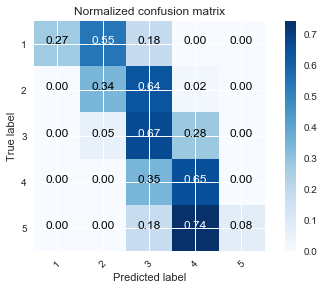

cross-validaiton scores:
0.429 (+/-0.090) for {'lasso__alpha': 9.9999999999999995e-08}
0.429 (+/-0.090) for {'lasso__alpha': 1.6681005372000591e-06}
0.429 (+/-0.090) for {'lasso__alpha': 2.782559402207126e-05}
0.430 (+/-0.089) for {'lasso__alpha': 0.00046415888336127822}
0.434 (+/-0.080) for {'lasso__alpha': 0.0077426368268112772}
0.235 (+/-0.039) for {'lasso__alpha': 0.12915496650148853}
-0.000 (+/-0.000) for {'lasso__alpha': 2.1544346900318865}
-0.000 (+/-0.000) for {'lasso__alpha': 35.938136638046402}
-0.000 (+/-0.000) for {'lasso__alpha': 599.48425031894214}
-0.000 (+/-0.000) for {'lasso__alpha': 10000.0}
training scores:
0.485 (+/-0.010) for {'lasso__alpha': 9.9999999999999995e-08}
0.485 (+/-0.010) for {'lasso__alpha': 1.6681005372000591e-06}
0.485 (+/-0.010) for {'lasso__alpha': 2.782559402207126e-05}
0.484 (+/-0.011) for {'lasso__alpha': 0.00046415888336127822}
0.474 (+/-0.010) for {'lasso__alpha': 0.0077426368268112772}
0.239 (+/-0.010) for {'lasso__alpha': 0.12915496650148853}

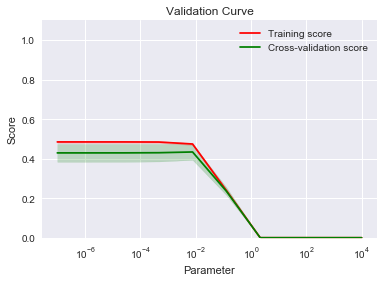

(array([[  3,   6,   2,   0,   0],
        [  0,  36,  67,   2,   0],
        [  0,  15, 184,  77,   0],
        [  0,   0,  93, 174,   0],
        [  0,   0,   7,  29,   3]], dtype=int64),
 GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=12, shuffle=True),
        error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
     verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=0,
    selection='cyclic', tol=0.0001, warm_start=False))]),
        fit_params=None, iid=True, n_jobs=4,
        param_grid={'lasso__alpha': array([  1.00000e-07,   1.66810e-06,   2.78256e-05,   4.64159e-04,
          7.74264e-03,   1.29155e-01,   2.15443e+00,   3.59381e+01,
          5.99484e+02,   1.00000e+04])},
        pre

In [17]:
# Lasso linear regression
steps_lasso = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('lasso', Lasso(random_state=0))]
pipeline_lasso = Pipeline(steps_lasso)

parameters_lasso = {'lasso__alpha':np.logspace(-7, 4, 10)}

score_func = r2_score
apply_model(X_all, y, pipeline_lasso, parameters_lasso, valid_param_name = 'lasso__alpha', scoring = score_func,
            learn_curve = 0, valid_curve = 1, classification=0, random_state = 12)


Accuracy on the test data: 55.014326647564474
Tuned model Parameters: {'elasticnet__l1_ratio': 9.9999999999999995e-08}
             precision    recall  f1-score   support

          1       1.00      0.09      0.17        11
          2       0.47      0.16      0.24       105
          3       0.50      0.71      0.59       276
          4       0.63      0.63      0.63       267
          5       0.00      0.00      0.00        39

avg / total       0.53      0.55      0.51       698

Normalized confusion matrix
[[ 0.09090909  0.54545455  0.36363636  0.          0.        ]
 [ 0.          0.16190476  0.82857143  0.00952381  0.        ]
 [ 0.          0.04710145  0.71376812  0.23913043  0.        ]
 [ 0.          0.          0.3670412   0.6329588   0.        ]
 [ 0.          0.          0.15384615  0.84615385  0.        ]]


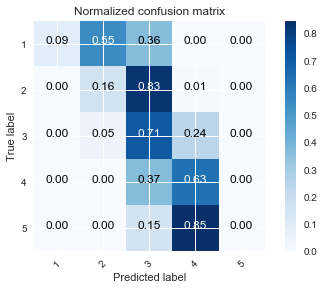

cross-validaiton scores:
0.402 (+/-0.060) for {'elasticnet__l1_ratio': 9.9999999999999995e-08}
0.402 (+/-0.060) for {'elasticnet__l1_ratio': 1.2915496650148827e-06}
0.402 (+/-0.060) for {'elasticnet__l1_ratio': 1.6681005372000593e-05}
0.402 (+/-0.060) for {'elasticnet__l1_ratio': 0.00021544346900318845}
0.399 (+/-0.060) for {'elasticnet__l1_ratio': 0.0027825594022071257}
0.345 (+/-0.051) for {'elasticnet__l1_ratio': 0.035938136638046257}
-0.000 (+/-0.000) for {'elasticnet__l1_ratio': 0.4641588833612782}
-0.000 (+/-0.000) for {'elasticnet__l1_ratio': 5.994842503189421}
-0.000 (+/-0.000) for {'elasticnet__l1_ratio': 77.426368268112782}
-0.000 (+/-0.000) for {'elasticnet__l1_ratio': 1000.0}
training scores:
0.427 (+/-0.009) for {'elasticnet__l1_ratio': 9.9999999999999995e-08}
0.427 (+/-0.009) for {'elasticnet__l1_ratio': 1.2915496650148827e-06}
0.427 (+/-0.009) for {'elasticnet__l1_ratio': 1.6681005372000593e-05}
0.427 (+/-0.009) for {'elasticnet__l1_ratio': 0.00021544346900318845}
0.422 

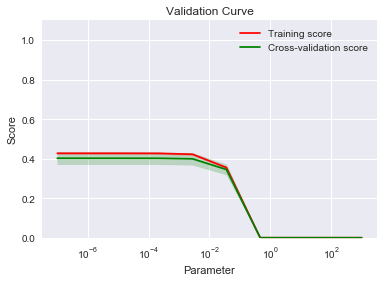

(array([[  1,   6,   4,   0,   0],
        [  0,  17,  87,   1,   0],
        [  0,  13, 197,  66,   0],
        [  0,   0,  98, 169,   0],
        [  0,   0,   6,  33,   0]], dtype=int64),
 GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=12, shuffle=True),
        error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
     verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=0, selection='cyclic', tol=0.0001, warm_start=False))]),
        fit_params=None, iid=True, n_jobs=4,
        param_grid={'elasticnet__l1_ratio': array([  1.00000e-07,   1.29155e-06,   1.66810e-05,   2.15443e-04,
          2.78256e-03,   3.59381e-02,   4.64159e-01,   5.99484e+00,
          7.74

In [21]:
# Elasticnet linear regression
steps_elastic = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('elasticnet', ElasticNet(random_state=0))]
pipeline_elastic = Pipeline(steps_elastic)

parameters_elastic = {'elasticnet__l1_ratio':np.logspace(-7, 3, 10)}

score_func = r2_score
apply_model(X_all, y, pipeline_elastic, parameters_elastic, valid_param_name = 'elasticnet__l1_ratio', 
            learn_curve = 0, valid_curve = 1, classification=0, random_state = 12)


#### Classification with Logistic Regression
##### Discussion
With the given and tuned parameters, logistic regression yields accuracy of $57\%$ and average f1-score of $0.57$. The unbiased generalization f1-score computed through nested cross-validation stays at $0.56$.

Model performance via nested cross-validaton mean score:0.559 (+/-0.022)
Accuracy on the test data: 57.73638968481375
Tuned model Parameters: {'logreg__C': 0.12915496650148853}
             precision    recall  f1-score   support

          1       0.57      0.36      0.44        11
          2       0.57      0.45      0.50       105
          3       0.55      0.55      0.55       276
          4       0.60      0.72      0.66       267
          5       0.62      0.26      0.36        39

avg / total       0.58      0.58      0.57       698

Normalized confusion matrix
[[ 0.36363636  0.54545455  0.09090909  0.          0.        ]
 [ 0.00952381  0.44761905  0.48571429  0.05714286  0.        ]
 [ 0.00362319  0.09782609  0.54710145  0.34057971  0.01086957]
 [ 0.00374532  0.00749064  0.26217228  0.71535581  0.01123596]
 [ 0.          0.02564103  0.07692308  0.64102564  0.25641026]]


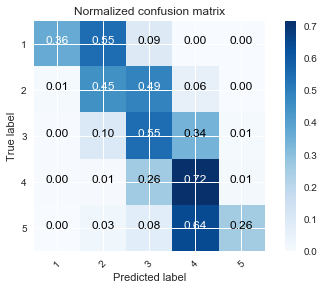

cross-validaiton scores:
0.395 (+/-0.002) for {'logreg__C': 9.9999999999999995e-08}
0.395 (+/-0.002) for {'logreg__C': 1.6681005372000591e-06}
0.531 (+/-0.035) for {'logreg__C': 2.782559402207126e-05}
0.533 (+/-0.037) for {'logreg__C': 0.00046415888336127822}
0.567 (+/-0.057) for {'logreg__C': 0.0077426368268112772}
0.569 (+/-0.057) for {'logreg__C': 0.12915496650148853}
0.558 (+/-0.048) for {'logreg__C': 2.1544346900318865}
0.554 (+/-0.051) for {'logreg__C': 35.938136638046402}
0.553 (+/-0.051) for {'logreg__C': 599.48425031894214}
0.553 (+/-0.051) for {'logreg__C': 10000.0}
training scores:
0.395 (+/-0.000) for {'logreg__C': 9.9999999999999995e-08}
0.395 (+/-0.000) for {'logreg__C': 1.6681005372000591e-06}
0.537 (+/-0.004) for {'logreg__C': 2.782559402207126e-05}
0.548 (+/-0.006) for {'logreg__C': 0.00046415888336127822}
0.618 (+/-0.005) for {'logreg__C': 0.0077426368268112772}
0.633 (+/-0.006) for {'logreg__C': 0.12915496650148853}
0.638 (+/-0.010) for {'logreg__C': 2.15443469003188

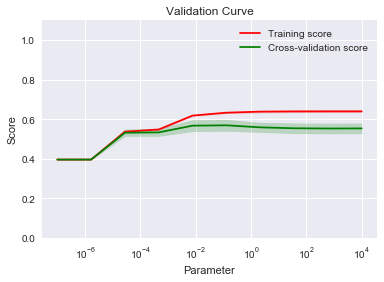

In [28]:
# Logistic regression for multiclass classification
steps_logreg = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(max_iter = 100, solver = 'newton-cg', multi_class = 'multinomial'))]
                  
pipeline_logreg = Pipeline(steps_logreg)

parameters_logreg = {'logreg__C':np.logspace(-7, 4, 10)}


score_func = f1_score

cnf_matrix, cv = apply_model(X_all, y, pipeline_logreg, parameters_logreg, valid_param_name='logreg__C', 
                             scoring = score_func, learn_curve = 0, valid_curve = 1, nested = True, 
                             classification=1, random_state = 12)

# Apply the classifier using a randomly oversampled dataset to account for the imbalanced data
#cnf_matrix, cv = apply_model(X_ros, y_ros, pipeline_logreg, parameters_logreg, 'logreg__C', 
#                             learn_curve = 1, valid_curve = 1, classification=1)

#cnf_matrix, cv = apply_model(X_smote, y_smote, pipeline_logreg, parameters_logreg, 'logreg__C', 
#                             learn_curve = 1, valid_curve = 1, classification=1)


#### Ordinal logistic regression using Mord

Here I used the logistic regression provided by mord python package for ordinal regression. Ordinal regression (also called "ordinal classification") is a type of regression analysis used for predicting an ordinal variable, i.e. a variable whose value exists on an arbitrary scale where only the relative ordering between different values is significant. As in my probelm I have a discrete 5-star rating, it can also be modeled by a regressor suitable to predict discrete outcomes. for this purpose [mord](https://goo.gl/hcMkYP) provides a collection of ordinal regression algorithms in Python, following a scikit-learn compatible API.
##### Discussion
Accuracy on the test data is at $58.4%$ and the average f1-score of $0.57$. Overall performance score from nested cross-validation is $0.57 \pm 0.025.$

Model performance via nested cross-validaton mean score:0.569 (+/-0.025)
Accuracy on the test data: 58.45272206303726
Tuned model Parameters: {'logclassmord__alpha': 35.938136638046402}
             precision    recall  f1-score   support

          1       0.75      0.27      0.40        11
          2       0.61      0.40      0.48       105
          3       0.55      0.59      0.57       276
          4       0.61      0.74      0.67       267
          5       1.00      0.08      0.14        39

avg / total       0.61      0.58      0.57       698

Normalized confusion matrix
[[ 0.27272727  0.63636364  0.          0.09090909  0.        ]
 [ 0.00952381  0.4         0.57142857  0.01904762  0.        ]
 [ 0.          0.07246377  0.58695652  0.34057971  0.        ]
 [ 0.          0.          0.25842697  0.74157303  0.        ]
 [ 0.          0.          0.1025641   0.82051282  0.07692308]]


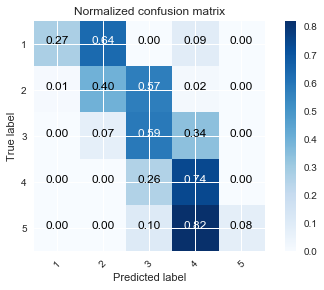

cross-validaiton scores:
0.570 (+/-0.068) for {'logclassmord__alpha': 9.9999999999999995e-08}
0.571 (+/-0.067) for {'logclassmord__alpha': 1.6681005372000591e-06}
0.571 (+/-0.067) for {'logclassmord__alpha': 2.782559402207126e-05}
0.571 (+/-0.067) for {'logclassmord__alpha': 0.00046415888336127822}
0.571 (+/-0.067) for {'logclassmord__alpha': 0.0077426368268112772}
0.571 (+/-0.067) for {'logclassmord__alpha': 0.12915496650148853}
0.569 (+/-0.062) for {'logclassmord__alpha': 2.1544346900318865}
0.573 (+/-0.065) for {'logclassmord__alpha': 35.938136638046402}
0.557 (+/-0.053) for {'logclassmord__alpha': 599.48425031894214}
0.530 (+/-0.046) for {'logclassmord__alpha': 10000.0}
training scores:
0.597 (+/-0.010) for {'logclassmord__alpha': 9.9999999999999995e-08}
0.597 (+/-0.010) for {'logclassmord__alpha': 1.6681005372000591e-06}
0.597 (+/-0.010) for {'logclassmord__alpha': 2.782559402207126e-05}
0.597 (+/-0.010) for {'logclassmord__alpha': 0.00046415888336127822}
0.597 (+/-0.010) for {'lo

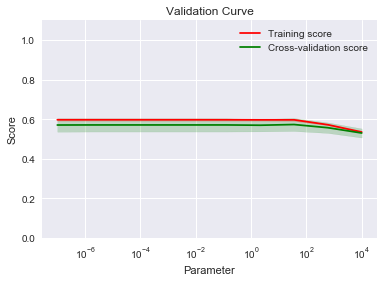

(array([[  3,   7,   0,   1,   0],
        [  1,  42,  60,   2,   0],
        [  0,  20, 162,  94,   0],
        [  0,   0,  69, 198,   0],
        [  0,   0,   4,  32,   3]], dtype=int64),
 GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=12, shuffle=True),
        error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
     verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logclassmord', LogisticIT(alpha=1.0, max_iter=100, verbose=0))]),
        fit_params=None, iid=True, n_jobs=4,
        param_grid={'logclassmord__alpha': array([  1.00000e-07,   1.66810e-06,   2.78256e-05,   4.64159e-04,
          7.74264e-03,   1.29155e-01,   2.15443e+00,   3.59381e+01,
          5.99484e+02,   1.00000e+04])},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=make_scorer(f1_score, average=micro), verbose=0))

In [36]:
# Ordindal regression using the mord package
import mord as m

steps_logclassmord = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                      ('scaler', StandardScaler()),
                      ('logclassmord', m.LogisticIT(max_iter = 100))]
                  
pipeline_logclassmord = Pipeline(steps_logclassmord)

parameters_logclassmord = {'logclassmord__alpha':np.logspace(-7, 4, 10)}

score_func = f1_score
#score_func = cohen_kappa_score
apply_model(X_all, y, pipeline_logclassmord, parameters_logclassmord, valid_param_name = 'logclassmord__alpha', 
            learn_curve = 0, valid_curve = 1, classification=1, nested = True, scoring = score_func,
            random_state = 12)

#### Linear classification with support vector classifier 
##### Discussion
The reported accuracy on the test data is $55\%$ and the avergae f1-score is at $0.53$. The overall generalization performance considering the f1-score is at $0.55 \pm 0.022$.

Model performance via nested cross-validaton mean score:0.555 (+/-0.022)
Accuracy on the test data: 55.014326647564474
Tuned model Parameters: {'lsvc__C': 0.001}
             precision    recall  f1-score   support

          1       1.00      0.09      0.17        11
          2       0.52      0.36      0.43       105
          3       0.53      0.54      0.53       276
          4       0.57      0.72      0.64       267
          5       0.56      0.13      0.21        39

avg / total       0.55      0.55      0.53       698

Normalized confusion matrix
[[ 0.09090909  0.72727273  0.09090909  0.          0.09090909]
 [ 0.          0.36190476  0.56190476  0.07619048  0.        ]
 [ 0.          0.08695652  0.53985507  0.36956522  0.00362319]
 [ 0.          0.00749064  0.26966292  0.71535581  0.00749064]
 [ 0.          0.02564103  0.02564103  0.82051282  0.12820513]]


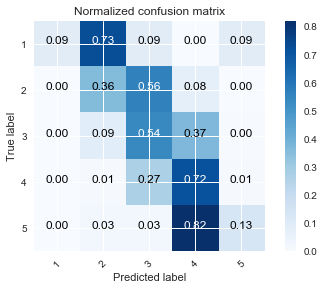

cross-validaiton scores:
0.535 (+/-0.057) for {'lsvc__C': 9.9999999999999995e-08}
0.536 (+/-0.060) for {'lsvc__C': 2.1544346900318822e-06}
0.555 (+/-0.042) for {'lsvc__C': 4.6415888336127723e-05}
0.560 (+/-0.055) for {'lsvc__C': 0.001}
0.556 (+/-0.047) for {'lsvc__C': 0.021544346900318822}
0.547 (+/-0.039) for {'lsvc__C': 0.46415888336127725}
0.486 (+/-0.064) for {'lsvc__C': 10.0}
0.438 (+/-0.061) for {'lsvc__C': 215.44346900318777}
0.439 (+/-0.057) for {'lsvc__C': 4641.5888336127728}
0.441 (+/-0.068) for {'lsvc__C': 100000.0}
training scores:
0.555 (+/-0.007) for {'lsvc__C': 9.9999999999999995e-08}
0.557 (+/-0.008) for {'lsvc__C': 2.1544346900318822e-06}
0.579 (+/-0.008) for {'lsvc__C': 4.6415888336127723e-05}
0.607 (+/-0.008) for {'lsvc__C': 0.001}
0.613 (+/-0.009) for {'lsvc__C': 0.021544346900318822}
0.619 (+/-0.009) for {'lsvc__C': 0.46415888336127725}
0.538 (+/-0.023) for {'lsvc__C': 10.0}
0.482 (+/-0.056) for {'lsvc__C': 215.44346900318777}
0.487 (+/-0.031) for {'lsvc__C': 4641.

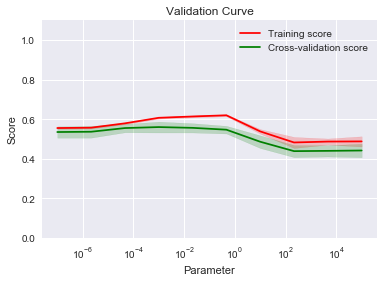

In [43]:
# Now try a linear classification using the support vector classifier
from sklearn.svm import LinearSVC

steps_lsvc = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('lsvc', LinearSVC(random_state=0, loss = 'squared_hinge'))]
pipeline_lsvc = Pipeline(steps_lsvc)

parameters_lsvc = {#'lsvc__loss':['hinge','squared_hinge']}
                   'lsvc__C':np.logspace(-7,5,10)}

# I see worse resutls on the test data when doing cross-validation. Perhaps I should do nexted cross-validation to get unbiased 
# prediction result on the test data? For example the default of C is one, but if I set it through gridsearch I get seemingly 
# worse results -->  Need to do exhaustive search, i.e., over a range. Look into this more closely however.

# Report results for different scoring
#score_func = precision_score
score_func = f1_score
#score_func = recall_score
#score_func = fbeta_score
#score_func = jaccard_similarity_score

cnf_matrix, cv = apply_model(X_all, y, pipeline_lsvc, parameters_lsvc, scoring = score_func, 
                             valid_param_name = 'lsvc__C', valid_curve=1, learn_curve = 0, 
                             nested = True, classification=1, random_state = 12)



In [ ]:
# Now usig the combined rankings
cnf_matrix, cv = apply_model(X_all, y_three_ranks, pipeline_lsvc, parameters_lsvc, learn_curve = 1, classification=1)

# Plot the confusion matrix
class_names = ['1', '2', '3']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### Random Forest Classification
##### Discussion
The reported accuracy on the test data is $55\%$ and the avergae f1-score is at $0.52$. The overall generalization performance considerinf the f1-score is at $0.56 \pm 0.018$.

Model performance via nested cross-validaton mean score:0.562 (+/-0.018)
Accuracy on the test data: 55.15759312320917
Tuned model Parameters: {'rfcl__n_estimators': 160, 'rfcl__max_features': 'auto', 'rfcl__max_depth': 22}
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        11
          2       0.57      0.16      0.25       105
          3       0.52      0.72      0.60       276
          4       0.59      0.60      0.60       267
          5       0.75      0.23      0.35        39

avg / total       0.56      0.55      0.52       698

Normalized confusion matrix
[[ 0.          0.72727273  0.27272727  0.          0.        ]
 [ 0.          0.16190476  0.75238095  0.08571429  0.        ]
 [ 0.          0.01811594  0.72101449  0.26086957  0.        ]
 [ 0.          0.          0.38951311  0.59925094  0.01123596]
 [ 0.          0.          0.02564103  0.74358974  0.23076923]]


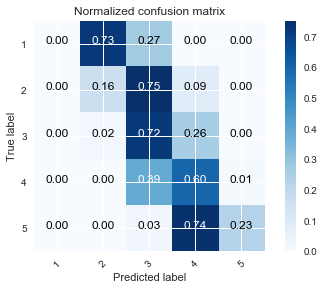

cross-validaiton scores:
0.549 (+/-0.063) for {'rfcl__n_estimators': 180, 'rfcl__max_features': 'log2', 'rfcl__max_depth': 12}
0.565 (+/-0.059) for {'rfcl__n_estimators': 130, 'rfcl__max_features': 'sqrt', 'rfcl__max_depth': 22}
0.560 (+/-0.054) for {'rfcl__n_estimators': 160, 'rfcl__max_features': 'sqrt', 'rfcl__max_depth': 30}
0.556 (+/-0.050) for {'rfcl__n_estimators': 190, 'rfcl__max_features': 'sqrt', 'rfcl__max_depth': 20}
0.567 (+/-0.062) for {'rfcl__n_estimators': 160, 'rfcl__max_features': 'auto', 'rfcl__max_depth': 22}
0.554 (+/-0.060) for {'rfcl__n_estimators': 110, 'rfcl__max_features': 'log2', 'rfcl__max_depth': 18}
0.561 (+/-0.051) for {'rfcl__n_estimators': 120, 'rfcl__max_features': 'auto', 'rfcl__max_depth': 20}
0.553 (+/-0.052) for {'rfcl__n_estimators': 150, 'rfcl__max_features': 'log2', 'rfcl__max_depth': 24}
0.566 (+/-0.061) for {'rfcl__n_estimators': 120, 'rfcl__max_features': 'sqrt', 'rfcl__max_depth': 14}
0.561 (+/-0.053) for {'rfcl__n_estimators': 110, 'rfcl__m

In [50]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier

steps_rfcl = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('rfcl', RandomForestClassifier(random_state=0, bootstrap=True, criterion='gini'))]
pipeline_rfcl = Pipeline(steps_rfcl)

parameters_rfcl = {'rfcl__max_depth':np.arange(2, 32, 2),
                   'rfcl__n_estimators':np.arange(100, 200, 10),
                   'rfcl__max_features':["auto", "sqrt", "log2"]}

score_func = f1_score
cnf_matrix, cv = apply_model(X_all, y, pipeline_rfcl, parameters_rfcl, scoring = score_func, 
                             valid_param_name = 'rfrg__n_estimators', valid_curve=0, learn_curve = 0, 
                             nested = True, classification=1, randomized_search = True, random_state = 12)




#### Gradient Boosting Classification

##### Discussion
The reported accuracy on the test data is $56\%$ and the avergae f1-score is at $0.53$. The overall generalization performance considering the f1-score is at $0.55 \pm 0.014$.
Here I also plotted the cofficients of the feature array as an indication of the relative feature importance. The higher means the more important the features in the classification performance. The top 10 most important features are as following:
1. HAI_1_SIR: Central line-associated blood stream infections in ICUs and select wards
2. MSPB_1: Medicare spending per beneficiary
3. EDAC_30_HF: Hospital return days for heart failure patients
4. OP_20: Average time patients spent in the emergency department before they were seen by a healthcare professional
5. OP_21: Average (median) time patients who came to the emergency department with broken bones had to wait before getting pain medication
6. OP_5: Average (median) Average (median) number of minutes before outpatients with chest pain or possible heart attack got an ECG
7. MORT_30_PN: Death rate for pneumonia patients
8. READM_30_PN: Rate of readmission for pneumonia patients
9. EDAC_30_AMI: Hospital return days for heart attack patients
10. HAI_2_SIR: Catheter-associated urinary tract infections in ICUs and select wards

<span style="color:Red ">** Question:**</span> What does this mean in terms of presenting the results to the customer?

Model performance via nested cross-validaton mean score:0.558 (+/-0.011)
Accuracy on the test data: 55.014326647564474
Tuned model Parameters: {'gbm__subsample': 1.0, 'gbm__n_estimators': 22, 'gbm__min_samples_split': 82, 'gbm__min_samples_leaf': 11, 'gbm__max_features': 7, 'gbm__max_depth': 11}
             precision    recall  f1-score   support

          1       1.00      0.09      0.17        11
          2       0.55      0.25      0.34       105
          3       0.52      0.66      0.58       276
          4       0.57      0.63      0.60       267
          5       0.75      0.23      0.35        39

avg / total       0.57      0.55      0.53       698

Normalized confusion matrix
[[ 0.09090909  0.90909091  0.          0.          0.        ]
 [ 0.          0.24761905  0.65714286  0.0952381   0.        ]
 [ 0.          0.0326087   0.6557971   0.3115942   0.        ]
 [ 0.          0.00749064  0.35580524  0.62546816  0.01123596]
 [ 0.          0.          0.02564103  0.74358974

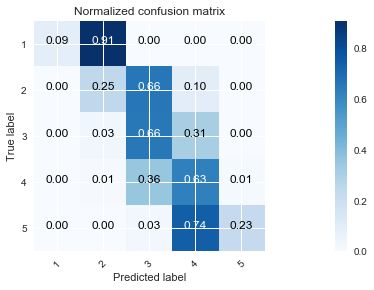

cross-validaiton scores:
0.553 (+/-0.050) for {'gbm__subsample': 0.8, 'gbm__n_estimators': 122, 'gbm__min_samples_split': 2, 'gbm__min_samples_leaf': 11, 'gbm__max_features': 15, 'gbm__max_depth': 9}
0.518 (+/-0.042) for {'gbm__subsample': 1.0, 'gbm__n_estimators': 2, 'gbm__min_samples_split': 42, 'gbm__min_samples_leaf': 16, 'gbm__max_features': 15, 'gbm__max_depth': 15}
0.557 (+/-0.053) for {'gbm__subsample': 0.7, 'gbm__n_estimators': 102, 'gbm__min_samples_split': 82, 'gbm__min_samples_leaf': 1, 'gbm__max_features': 7, 'gbm__max_depth': 7}
0.554 (+/-0.055) for {'gbm__subsample': 1.0, 'gbm__n_estimators': 82, 'gbm__min_samples_split': 42, 'gbm__min_samples_leaf': 6, 'gbm__max_features': 11, 'gbm__max_depth': 9}
0.554 (+/-0.043) for {'gbm__subsample': 0.8, 'gbm__n_estimators': 82, 'gbm__min_samples_split': 42, 'gbm__min_samples_leaf': 1, 'gbm__max_features': 11, 'gbm__max_depth': 7}
0.543 (+/-0.042) for {'gbm__subsample': 0.6, 'gbm__n_estimators': 182, 'gbm__min_samples_split': 62, 'g

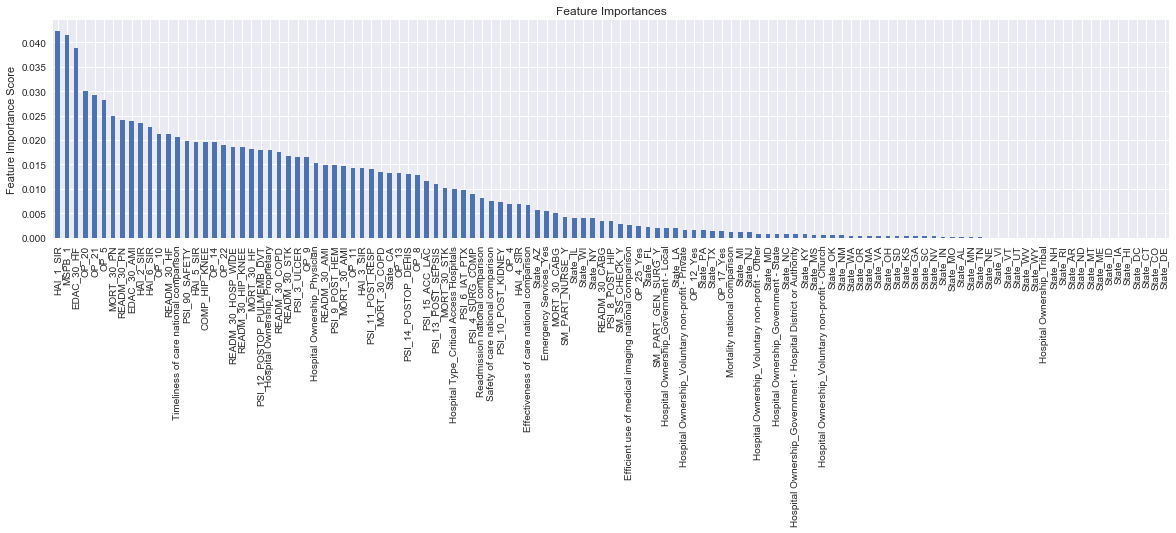

In [86]:
# There are two types of parameters to be tuned here: 1- Tree-based and 2- boosting parameters
# There are no optimum values for learning rate, low values always work better given that we train on sufficient number of trees
# Notes to keep in mind: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

steps_gbm = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
             ('scaler', StandardScaler()),
             ('gbm', GradientBoostingClassifier(random_state=0, learning_rate=0.1))]
pipeline_gbm = Pipeline(steps_gbm)

parameters_gbm = {'gbm__n_estimators':np.arange(2,200, 20),
                  'gbm__subsample':[0.6, 0.7, 0.8, 0.9, 1.0],
                  'gbm__max_depth':np.arange(5,16,2),
                  'gbm__min_samples_split':np.arange(2,100,10),
                  'gbm__min_samples_leaf':np.arange(1,30, 5),
                  'gbm__max_features':np.arange(7,20,2)}

                        
cnf_matrix, cv = apply_model(X_all, y, pipeline_gbm, parameters_gbm, 
                             valid_param_name='gbm__n_estimators',valid_curve = 0, 
                             learn_curve = 0, classification=1, nested = True, 
                             random_state = 12, feature_imp = True, randomized_search = True,
                             named_step='gbm')
 

#### Extreme Gradient Boosting Classification

The name [xgboost](https://github.com/dmlc/xgboost), refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

##### Discussion
The reported accuracy on the test data is $57\%$ and the avergae f1-score is at $0.56$. The overall generalization performance considering the f1-score is at $ 0.57 \pm 0.016$.

Model performance via nested cross-validaton mean score:0.567 (+/-0.016)
Accuracy on the test data: 57.44985673352435
Tuned model Parameters: {'xgboost__n_estimators': 160, 'xgboost__max_depth': 2}
             precision    recall  f1-score   support

          1       0.67      0.18      0.29        11
          2       0.60      0.36      0.45       105
          3       0.55      0.61      0.57       276
          4       0.59      0.69      0.63       267
          5       0.69      0.28      0.40        39

avg / total       0.58      0.57      0.56       698

Normalized confusion matrix
[[ 0.18181818  0.81818182  0.          0.          0.        ]
 [ 0.          0.36190476  0.56190476  0.07619048  0.        ]
 [ 0.00362319  0.05072464  0.60507246  0.34057971  0.        ]
 [ 0.          0.00749064  0.28838951  0.68539326  0.01872659]
 [ 0.          0.          0.05128205  0.66666667  0.28205128]]


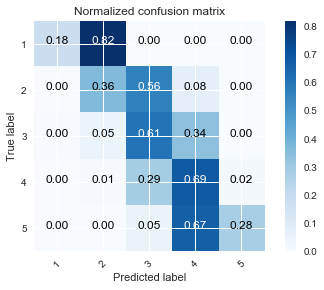

cross-validaiton scores:
0.545 (+/-0.035) for {'xgboost__n_estimators': 140, 'xgboost__max_depth': 62}
0.547 (+/-0.035) for {'xgboost__n_estimators': 60, 'xgboost__max_depth': 102}
0.558 (+/-0.052) for {'xgboost__n_estimators': 180, 'xgboost__max_depth': 22}
0.543 (+/-0.037) for {'xgboost__n_estimators': 130, 'xgboost__max_depth': 82}
0.547 (+/-0.038) for {'xgboost__n_estimators': 80, 'xgboost__max_depth': 82}
0.559 (+/-0.051) for {'xgboost__n_estimators': 170, 'xgboost__max_depth': 22}
0.543 (+/-0.037) for {'xgboost__n_estimators': 130, 'xgboost__max_depth': 122}
0.554 (+/-0.045) for {'xgboost__n_estimators': 50, 'xgboost__max_depth': 42}
0.568 (+/-0.053) for {'xgboost__n_estimators': 160, 'xgboost__max_depth': 2}
0.540 (+/-0.039) for {'xgboost__n_estimators': 20, 'xgboost__max_depth': 82}
training scores:
1.000 (+/-0.000) for {'xgboost__n_estimators': 140, 'xgboost__max_depth': 62}
1.000 (+/-0.000) for {'xgboost__n_estimators': 60, 'xgboost__max_depth': 102}
1.000 (+/-0.000) for {'xg

In [15]:
# XGBoost classifier
# Over all parameters have been divided to:
# 1. General Parameters, 2- Booster Parameters, 3- Learning Task Parameters

from xgboost.sklearn import XGBClassifier  # sklearn wrapper for XGboost
from sklearn.metrics import accuracy_score

# Fix some parameter values
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=250,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

steps_xgboost = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('xgboost', xgb1)]
pipeline_xgboost = Pipeline(steps_xgboost)

parameters_xgboost = {'xgboost__max_depth':np.arange(2,128, 20),
                      'xgboost__n_estimators':np.arange(10,200, 10)}

cnf_matrix, cv = apply_model(X_all, y, pipeline_xgboost, parameters_xgboost, 
                             valid_param_name='xgboost__max_depth',valid_curve = 0, 
                             learn_curve = 0, classification=1, nested = True, 
                             random_state = 12, feature_imp = False, randomized_search = True,
                             named_step='gbm')


#### Adaboost Classification

##### Discussion
The reported accuracy on the test data is $53.7\%$ and the avergae f1-score is at $0.49$. The overall generalization performance considering the f1-score is at $0.53 \pm 0.013$.

Accuracy on the test data: 52.00573065902579
Tuned model Parameters: {'adrg__loss': 'exponential', 'adrg__n_estimators': 160}
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        11
          2       0.43      0.03      0.05       105
          3       0.48      0.89      0.63       276
          4       0.63      0.42      0.51       267
          5       0.00      0.00      0.00        39

avg / total       0.50      0.52      0.45       698

Normalized confusion matrix
[[ 0.          0.36363636  0.63636364  0.          0.        ]
 [ 0.          0.02857143  0.96190476  0.00952381  0.        ]
 [ 0.          0.          0.89492754  0.10507246  0.        ]
 [ 0.          0.          0.57677903  0.42322097  0.        ]
 [ 0.          0.          0.07692308  0.92307692  0.        ]]


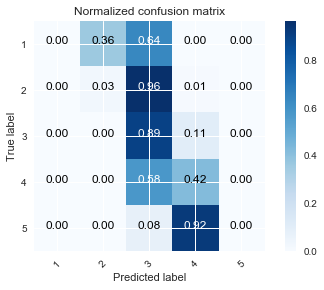

cross-validaiton scores:
0.308 (+/-0.056) for {'adrg__loss': 'linear', 'adrg__n_estimators': 10}
0.331 (+/-0.038) for {'adrg__loss': 'linear', 'adrg__n_estimators': 60}
0.335 (+/-0.035) for {'adrg__loss': 'linear', 'adrg__n_estimators': 110}
0.336 (+/-0.033) for {'adrg__loss': 'linear', 'adrg__n_estimators': 160}
0.312 (+/-0.065) for {'adrg__loss': 'square', 'adrg__n_estimators': 10}
0.312 (+/-0.030) for {'adrg__loss': 'square', 'adrg__n_estimators': 60}
0.316 (+/-0.027) for {'adrg__loss': 'square', 'adrg__n_estimators': 110}
0.322 (+/-0.022) for {'adrg__loss': 'square', 'adrg__n_estimators': 160}
0.311 (+/-0.050) for {'adrg__loss': 'exponential', 'adrg__n_estimators': 10}
0.336 (+/-0.037) for {'adrg__loss': 'exponential', 'adrg__n_estimators': 60}
0.343 (+/-0.034) for {'adrg__loss': 'exponential', 'adrg__n_estimators': 110}
0.345 (+/-0.034) for {'adrg__loss': 'exponential', 'adrg__n_estimators': 160}
training scores:
0.345 (+/-0.012) for {'adrg__loss': 'linear', 'adrg__n_estimators': 

In [26]:
# Adaboost regression
from sklearn.ensemble import AdaBoostRegressor

steps_adrg = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('adrg', AdaBoostRegressor(random_state=0, learning_rate = 0.1))]
pipeline_adrg = Pipeline(steps_adrg)

parameters_adrg = {'adrg__n_estimators':np.arange(10,200, 50),
                   'adrg__loss':["linear", "square", "exponential"]}

cnf_matrix, cv =apply_model(X_all, y, pipeline_adrg, parameters_adrg, 
                             valid_param_name='adrg__n_estimators',valid_curve = 0, 
                             learn_curve = 0, classification=0, nested = False, scoring = r2_score,
                             random_state = 12, feature_imp = False, randomized_search = False)

Model performance via nested cross-validaton mean score:0.537 (+/-0.013)
Accuracy on the test data: 53.72492836676218
Tuned model Parameters: {'adcl__n_estimators': 160}
             precision    recall  f1-score   support

          1       0.56      0.45      0.50        11
          2       0.82      0.09      0.16       105
          3       0.50      0.64      0.56       276
          4       0.56      0.69      0.62       267
          5       0.00      0.00      0.00        39

avg / total       0.55      0.54      0.49       698

Normalized confusion matrix
[[ 0.45454545  0.18181818  0.36363636  0.          0.        ]
 [ 0.02857143  0.08571429  0.8         0.08571429  0.        ]
 [ 0.00362319  0.          0.64130435  0.35507246  0.        ]
 [ 0.          0.          0.31086142  0.68913858  0.        ]
 [ 0.          0.          0.07692308  0.92307692  0.        ]]


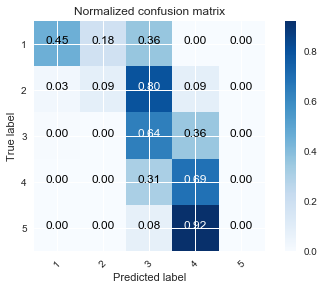

cross-validaiton scores:
0.516 (+/-0.044) for {'adcl__n_estimators': 10}
0.530 (+/-0.040) for {'adcl__n_estimators': 60}
0.534 (+/-0.026) for {'adcl__n_estimators': 110}
0.535 (+/-0.037) for {'adcl__n_estimators': 160}
training scores:
0.519 (+/-0.005) for {'adcl__n_estimators': 10}
0.531 (+/-0.007) for {'adcl__n_estimators': 60}
0.535 (+/-0.010) for {'adcl__n_estimators': 110}
0.539 (+/-0.011) for {'adcl__n_estimators': 160}


In [32]:
# Adaboost Classification
from sklearn.ensemble import AdaBoostClassifier

steps_adcl = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('adcl', AdaBoostClassifier(random_state=0, learning_rate = 0.1))]
pipeline_adcl = Pipeline(steps_adcl)

parameters_adcl = {'adcl__n_estimators':np.arange(10,200, 50)}

cnf_matrix, cv =apply_model(X_all, y, pipeline_adcl, parameters_adcl, 
                             valid_param_name='adcl__n_estimators',valid_curve = 0, 
                             learn_curve = 0, classification=1, nested = True, scoring = f1_score,
                             random_state = 12, feature_imp = False, randomized_search = False)

#####  KNN Classification

##### Discussion
The reported accuracy on the test data is $53\%$ and the avergae f1-score is at $0.51$. The overall generalization performance considerinf the f1-score is at $ 0.50 \pm 0.019 $ which can be an indication of the impact of imbalanced dataset on KNN.

Model performance via nested cross-validaton mean score:0.330 (+/-0.023)
Accuracy on the test data: 53.15186246418339
Tuned model Parameters: {'knnrg__n_neighbors': 15, 'knnrg__weights': 'distance'}
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        11
          2       0.59      0.22      0.32       105
          3       0.50      0.57      0.53       276
          4       0.55      0.70      0.62       267
          5       0.50      0.08      0.13        39

avg / total       0.53      0.53      0.50       698

Normalized confusion matrix
[[ 0.          0.63636364  0.27272727  0.          0.09090909]
 [ 0.          0.21904762  0.66666667  0.11428571  0.        ]
 [ 0.          0.02898551  0.56884058  0.40217391  0.        ]
 [ 0.          0.00374532  0.28464419  0.70411985  0.00749064]
 [ 0.          0.          0.15384615  0.76923077  0.07692308]]


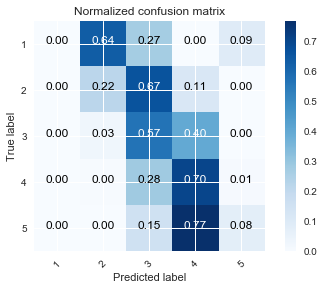

cross-validaiton scores:
0.283 (+/-0.069) for {'knnrg__n_neighbors': 5, 'knnrg__weights': 'uniform'}
0.286 (+/-0.071) for {'knnrg__n_neighbors': 5, 'knnrg__weights': 'distance'}
0.328 (+/-0.085) for {'knnrg__n_neighbors': 10, 'knnrg__weights': 'uniform'}
0.332 (+/-0.085) for {'knnrg__n_neighbors': 10, 'knnrg__weights': 'distance'}
0.336 (+/-0.078) for {'knnrg__n_neighbors': 15, 'knnrg__weights': 'uniform'}
0.340 (+/-0.079) for {'knnrg__n_neighbors': 15, 'knnrg__weights': 'distance'}
0.328 (+/-0.064) for {'knnrg__n_neighbors': 20, 'knnrg__weights': 'uniform'}
0.333 (+/-0.067) for {'knnrg__n_neighbors': 20, 'knnrg__weights': 'distance'}
0.329 (+/-0.056) for {'knnrg__n_neighbors': 25, 'knnrg__weights': 'uniform'}
0.334 (+/-0.059) for {'knnrg__n_neighbors': 25, 'knnrg__weights': 'distance'}
training scores:
0.525 (+/-0.010) for {'knnrg__n_neighbors': 5, 'knnrg__weights': 'uniform'}
1.000 (+/-0.000) for {'knnrg__n_neighbors': 5, 'knnrg__weights': 'distance'}
0.451 (+/-0.009) for {'knnrg__n_

In [22]:
# KNN Regression
from sklearn.neighbors import KNeighborsRegressor

steps_knnrg = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('knnrg', KNeighborsRegressor())]
pipeline_knnrg = Pipeline(steps_knnrg)

parameters_knnrg = {'knnrg__n_neighbors':np.arange(5,30, 5),
                   'knnrg__weights':['uniform','distance']}

score_func = r2_score
cnf_matrix, cv = apply_model(X_all, y, pipeline_knnrg, parameters_knnrg, 
                             valid_param_name='knnrg__n_neighbors',valid_curve = 0, 
                             learn_curve = 0, classification=0, nested = True, 
                             random_state = 12, feature_imp = False, randomized_search = False)

Model performance via nested cross-validaton mean score:0.498 (+/-0.019)
Accuracy on the test data: 52.72206303724928
Tuned model Parameters: {'knncl__n_neighbors': 10, 'knncl__weights': 'uniform'}
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        11
          2       0.50      0.44      0.47       105
          3       0.53      0.44      0.48       276
          4       0.53      0.73      0.62       267
          5       0.50      0.18      0.26        39

avg / total       0.52      0.53      0.51       698

Normalized confusion matrix
[[ 0.          0.81818182  0.09090909  0.          0.09090909]
 [ 0.          0.43809524  0.38095238  0.18095238  0.        ]
 [ 0.          0.11594203  0.4384058   0.44202899  0.00362319]
 [ 0.          0.01872659  0.23595506  0.72659176  0.01872659]
 [ 0.          0.          0.1025641   0.71794872  0.17948718]]


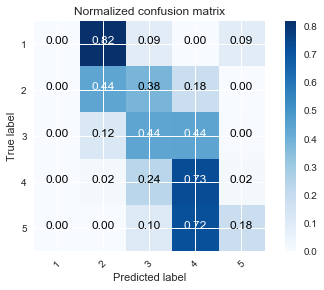

cross-validaiton scores:
0.491 (+/-0.072) for {'knncl__n_neighbors': 5, 'knncl__weights': 'uniform'}
0.489 (+/-0.074) for {'knncl__n_neighbors': 5, 'knncl__weights': 'distance'}
0.516 (+/-0.057) for {'knncl__n_neighbors': 10, 'knncl__weights': 'uniform'}
0.511 (+/-0.063) for {'knncl__n_neighbors': 10, 'knncl__weights': 'distance'}
0.502 (+/-0.029) for {'knncl__n_neighbors': 15, 'knncl__weights': 'uniform'}
0.496 (+/-0.036) for {'knncl__n_neighbors': 15, 'knncl__weights': 'distance'}
0.502 (+/-0.035) for {'knncl__n_neighbors': 20, 'knncl__weights': 'uniform'}
0.504 (+/-0.036) for {'knncl__n_neighbors': 20, 'knncl__weights': 'distance'}
0.497 (+/-0.032) for {'knncl__n_neighbors': 25, 'knncl__weights': 'uniform'}
0.500 (+/-0.034) for {'knncl__n_neighbors': 25, 'knncl__weights': 'distance'}
training scores:
0.655 (+/-0.011) for {'knncl__n_neighbors': 5, 'knncl__weights': 'uniform'}
1.000 (+/-0.000) for {'knncl__n_neighbors': 5, 'knncl__weights': 'distance'}
0.610 (+/-0.007) for {'knncl__n_

In [33]:
# KNN Classification
from sklearn.neighbors import KNeighborsClassifier

steps_knncl = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
               ('scaler', StandardScaler()),
               ('knncl', KNeighborsClassifier())]
pipeline_knncl = Pipeline(steps_knncl)

parameters_knncl = {'knncl__n_neighbors':np.arange(5,30, 5),
                   'knncl__weights':['uniform','distance']}

cnf_matrix, cv = apply_model(X_all, y, pipeline_knncl, parameters_knncl, 
                             valid_param_name='knncl__n_neighbors',valid_curve = 0, 
                             learn_curve = 0, classification=1, nested = True, scoring = f1_score, 
                             random_state = 12, feature_imp = False, randomized_search = False)

#### Support Vector Classifier with RBF kernel

##### Discussion
The reported accuracy on the test data is $58\%$ and the avergae f1-score is at $0.56$. The overall generalization performance considerinf the f1-score is at $ 0.57 \pm 0.020 $. 

Model performance via nested cross-validaton mean score:0.571 (+/-0.020)
Accuracy on the test data: 57.73638968481375
Tuned model Parameters: {'SVM__C': 10.0}
             precision    recall  f1-score   support

          1       0.60      0.27      0.37        11
          2       0.57      0.42      0.48       105
          3       0.55      0.58      0.56       276
          4       0.60      0.72      0.66       267
          5       0.80      0.10      0.18        39

avg / total       0.59      0.58      0.56       698

Normalized confusion matrix
[[ 0.27272727  0.63636364  0.09090909  0.          0.        ]
 [ 0.00952381  0.41904762  0.52380952  0.04761905  0.        ]
 [ 0.          0.08695652  0.57608696  0.33695652  0.        ]
 [ 0.00374532  0.00374532  0.2659176   0.72284644  0.00374532]
 [ 0.          0.02564103  0.07692308  0.79487179  0.1025641 ]]


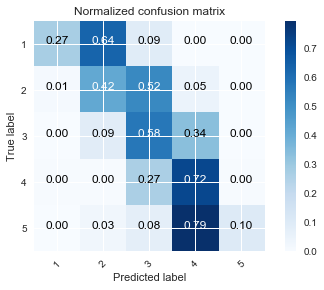

cross-validaiton scores:
0.395 (+/-0.002) for {'SVM__C': 9.9999999999999995e-08}
0.395 (+/-0.002) for {'SVM__C': 2.1544346900318822e-06}
0.395 (+/-0.002) for {'SVM__C': 4.6415888336127723e-05}
0.395 (+/-0.002) for {'SVM__C': 0.001}
0.395 (+/-0.002) for {'SVM__C': 0.021544346900318822}
0.526 (+/-0.049) for {'SVM__C': 0.46415888336127725}
0.578 (+/-0.058) for {'SVM__C': 10.0}
0.523 (+/-0.055) for {'SVM__C': 215.44346900318777}
0.494 (+/-0.056) for {'SVM__C': 4641.5888336127728}
0.494 (+/-0.056) for {'SVM__C': 100000.0}
training scores:
0.395 (+/-0.000) for {'SVM__C': 9.9999999999999995e-08}
0.395 (+/-0.000) for {'SVM__C': 2.1544346900318822e-06}
0.395 (+/-0.000) for {'SVM__C': 4.6415888336127723e-05}
0.395 (+/-0.000) for {'SVM__C': 0.001}
0.395 (+/-0.000) for {'SVM__C': 0.021544346900318822}
0.549 (+/-0.007) for {'SVM__C': 0.46415888336127725}
0.690 (+/-0.006) for {'SVM__C': 10.0}
0.955 (+/-0.005) for {'SVM__C': 215.44346900318777}
1.000 (+/-0.000) for {'SVM__C': 4641.5888336127728}
1.00

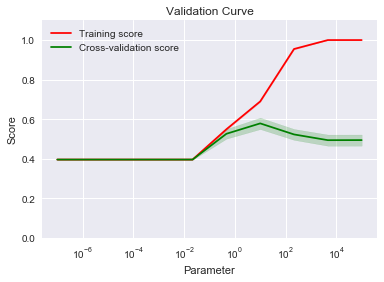

In [36]:
# SVM 
# Setup the pipeline
steps_svm_mean = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                  ('scaler', StandardScaler()),
                  ('SVM', svm.SVC(gamma=0.001))]
pipeline_svm = Pipeline(steps_svm_mean)

# Specify the hyperparameter space
parameters_svm = {'SVM__C':np.logspace(-7, 5, 10)}


cnf_matrix = apply_model(X_all, y, pipeline_svm, parameters_svm, 
                        valid_param_name='SVM__C',valid_curve = 1, 
                        learn_curve = 0, classification=1, nested = True, 
                        random_state = 12, feature_imp = False, randomized_search = False)


#### Summary Performance Comparison of the models

####  Classification using combined rankings 
In this section, I experiment with the performace of the classifiers on the combined ranking labels. The goal here is to have a classifier than can predict the rating *status*  of a hospital with respect to avergae performance. In this new ranking system, star rating of 3 in the original dataset would be considered an average rating.

|<center>Model</center>||Accuracy on Test data||Model performance via nested CV||Average f1-score on the test data|
|-----|-----------------------------------------------------|---------------------------------|
|<center>SVM</center> || <center> $61\%$</center>||<center>$ 0.63 \pm 0.020 $</center>||<center> $0.61$</center>|
|<center>Gradient Boosting</center> || <center>$65\%$</center>|| <center>$0.62 \pm 0.009$</center>||<center> $0.65$</center>|
|<center>xgboost</center> || <center>$62 \%$</center>|| <center>$0.62 \pm 0.009$</center>||<center> $0.61$ </center>|
|<center>Ordinal Regression</center> || <center>$62\%$</center>|| <center>$0.62 \pm 0.011$</center>||<center>$0.61$</center>|
|<center>Logistic Regression</center>|| <center>$62\%$</center>|| <center>$0.63 \pm 0.006$</center>||<center>$0.62$</center>|


Model performance via nested cross-validaton mean score:0.629 (+/-0.008)
Accuracy on the test data: 61.174785100286535
Tuned model Parameters: {'SVM__C': 10.0}
             precision    recall  f1-score   support

          1       0.62      0.42      0.50       116
          2       0.53      0.53      0.53       276
          3       0.67      0.75      0.71       306

avg / total       0.61      0.61      0.61       698

Normalized confusion matrix
[[ 0.42241379  0.47413793  0.10344828]
 [ 0.10144928  0.5326087   0.36594203]
 [ 0.00653595  0.23856209  0.75490196]]


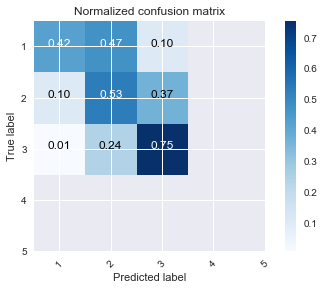

cross-validaiton scores:
0.438 (+/-0.001) for {'SVM__C': 9.9999999999999995e-08}
0.438 (+/-0.001) for {'SVM__C': 2.1544346900318822e-06}
0.438 (+/-0.001) for {'SVM__C': 4.6415888336127723e-05}
0.438 (+/-0.001) for {'SVM__C': 0.001}
0.438 (+/-0.001) for {'SVM__C': 0.021544346900318822}
0.597 (+/-0.051) for {'SVM__C': 0.46415888336127725}
0.631 (+/-0.040) for {'SVM__C': 10.0}
0.591 (+/-0.046) for {'SVM__C': 215.44346900318777}
0.564 (+/-0.064) for {'SVM__C': 4641.5888336127728}
0.565 (+/-0.067) for {'SVM__C': 100000.0}
training scores:
0.438 (+/-0.000) for {'SVM__C': 9.9999999999999995e-08}
0.438 (+/-0.000) for {'SVM__C': 2.1544346900318822e-06}
0.438 (+/-0.000) for {'SVM__C': 4.6415888336127723e-05}
0.438 (+/-0.000) for {'SVM__C': 0.001}
0.438 (+/-0.000) for {'SVM__C': 0.021544346900318822}
0.621 (+/-0.008) for {'SVM__C': 0.46415888336127725}
0.745 (+/-0.006) for {'SVM__C': 10.0}
0.967 (+/-0.005) for {'SVM__C': 215.44346900318777}
1.000 (+/-0.000) for {'SVM__C': 4641.5888336127728}
1.00

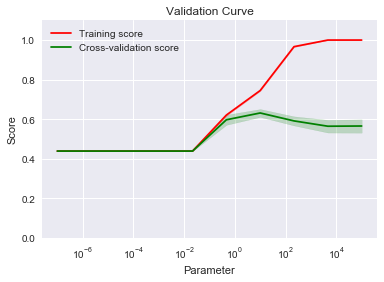

In [16]:
# Pick some of the better performance classifier and report accuracy on combined ratings
# SVM 
# Setup the pipeline
steps_svm_mean = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                  ('scaler', StandardScaler()),
                  ('SVM', svm.SVC(gamma=0.001))]
pipeline_svm = Pipeline(steps_svm_mean)

# Specify the hyperparameter space
parameters_svm = {'SVM__C':np.logspace(-7, 5, 10)}


cnf_matrix = apply_model(X_all, y_three_ranks, pipeline_svm, parameters_svm, 
                        valid_param_name='SVM__C',valid_curve = 1, 
                        learn_curve = 0, classification=1, nested = True, 
                        random_state = 12, feature_imp = False, randomized_search = False)


Model performance via nested cross-validaton mean score:0.624 (+/-0.009)
Accuracy on the test data: 65.18624641833811
Tuned model Parameters: {'gbm__subsample': 0.9, 'gbm__n_estimators': 62, 'gbm__min_samples_split': 32, 'gbm__min_samples_leaf': 6, 'gbm__max_features': 19, 'gbm__max_depth': 13}
             precision    recall  f1-score   support

          1       0.74      0.40      0.52       116
          2       0.56      0.66      0.61       276
          3       0.72      0.74      0.73       306

avg / total       0.66      0.65      0.65       698

Normalized confusion matrix
[[ 0.39655172  0.54310345  0.06034483]
 [ 0.05072464  0.66304348  0.28623188]
 [ 0.00653595  0.25490196  0.73856209]]


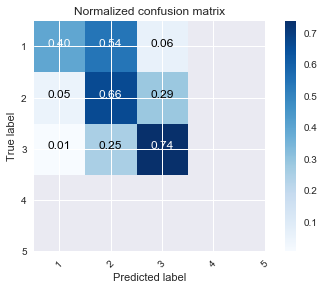

cross-validaiton scores:
0.621 (+/-0.038) for {'gbm__subsample': 0.7, 'gbm__n_estimators': 42, 'gbm__min_samples_split': 62, 'gbm__min_samples_leaf': 26, 'gbm__max_features': 19, 'gbm__max_depth': 7}
0.617 (+/-0.042) for {'gbm__subsample': 0.7, 'gbm__n_estimators': 22, 'gbm__min_samples_split': 2, 'gbm__min_samples_leaf': 11, 'gbm__max_features': 13, 'gbm__max_depth': 9}
0.616 (+/-0.052) for {'gbm__subsample': 1.0, 'gbm__n_estimators': 22, 'gbm__min_samples_split': 72, 'gbm__min_samples_leaf': 21, 'gbm__max_features': 9, 'gbm__max_depth': 7}
0.622 (+/-0.042) for {'gbm__subsample': 0.7, 'gbm__n_estimators': 122, 'gbm__min_samples_split': 52, 'gbm__min_samples_leaf': 16, 'gbm__max_features': 7, 'gbm__max_depth': 9}
0.620 (+/-0.050) for {'gbm__subsample': 0.8, 'gbm__n_estimators': 142, 'gbm__min_samples_split': 22, 'gbm__min_samples_leaf': 21, 'gbm__max_features': 19, 'gbm__max_depth': 15}
0.620 (+/-0.051) for {'gbm__subsample': 1.0, 'gbm__n_estimators': 62, 'gbm__min_samples_split': 72, 

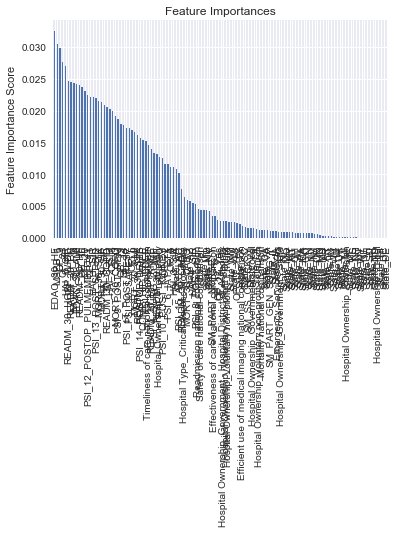

In [17]:
# Gradient boosting
steps_gbm = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
             ('scaler', StandardScaler()),
             ('gbm', GradientBoostingClassifier(random_state=0, learning_rate=0.1))]
pipeline_gbm = Pipeline(steps_gbm)

parameters_gbm = {'gbm__n_estimators':np.arange(2,200, 20),
                  'gbm__subsample':[0.6, 0.7, 0.8, 0.9, 1.0],
                  'gbm__max_depth':np.arange(5,16,2),
                  'gbm__min_samples_split':np.arange(2,100,10),
                  'gbm__min_samples_leaf':np.arange(1,30, 5),
                  'gbm__max_features':np.arange(7,20,2)}

                        
cnf_matrix, cv = apply_model(X_all, y_three_ranks, pipeline_gbm, parameters_gbm, 
                             valid_param_name='gbm__n_estimators',valid_curve = 0, 
                             learn_curve = 0, classification=1, nested = True, 
                             random_state = 12, feature_imp = True, randomized_search = True,
                             named_step='gbm')

Model performance via nested cross-validaton mean score:0.624 (+/-0.011)
Accuracy on the test data: 61.60458452722063
Tuned model Parameters: {'logclassmord__alpha': 9.9999999999999995e-08}
             precision    recall  f1-score   support

          1       0.65      0.47      0.54       116
          2       0.53      0.53      0.53       276
          3       0.68      0.75      0.71       306

avg / total       0.61      0.62      0.61       698

Normalized confusion matrix
[[ 0.46551724  0.46551724  0.06896552]
 [ 0.10144928  0.52536232  0.37318841]
 [ 0.00326797  0.24183007  0.75490196]]


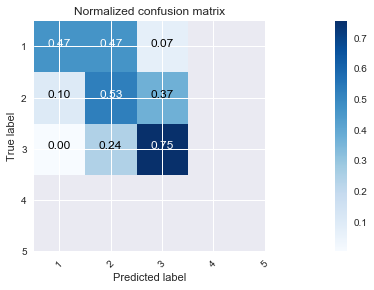

cross-validaiton scores:
0.631 (+/-0.047) for {'logclassmord__alpha': 9.9999999999999995e-08}
0.631 (+/-0.047) for {'logclassmord__alpha': 1.6681005372000591e-06}
0.631 (+/-0.047) for {'logclassmord__alpha': 2.782559402207126e-05}
0.631 (+/-0.047) for {'logclassmord__alpha': 0.00046415888336127822}
0.631 (+/-0.047) for {'logclassmord__alpha': 0.0077426368268112772}
0.631 (+/-0.047) for {'logclassmord__alpha': 0.12915496650148853}
0.630 (+/-0.049) for {'logclassmord__alpha': 2.1544346900318865}
0.626 (+/-0.050) for {'logclassmord__alpha': 35.938136638046402}
0.625 (+/-0.038) for {'logclassmord__alpha': 599.48425031894214}
0.566 (+/-0.048) for {'logclassmord__alpha': 10000.0}
training scores:
0.660 (+/-0.008) for {'logclassmord__alpha': 9.9999999999999995e-08}
0.660 (+/-0.008) for {'logclassmord__alpha': 1.6681005372000591e-06}
0.660 (+/-0.008) for {'logclassmord__alpha': 2.782559402207126e-05}
0.660 (+/-0.008) for {'logclassmord__alpha': 0.00046415888336127822}
0.660 (+/-0.008) for {'lo

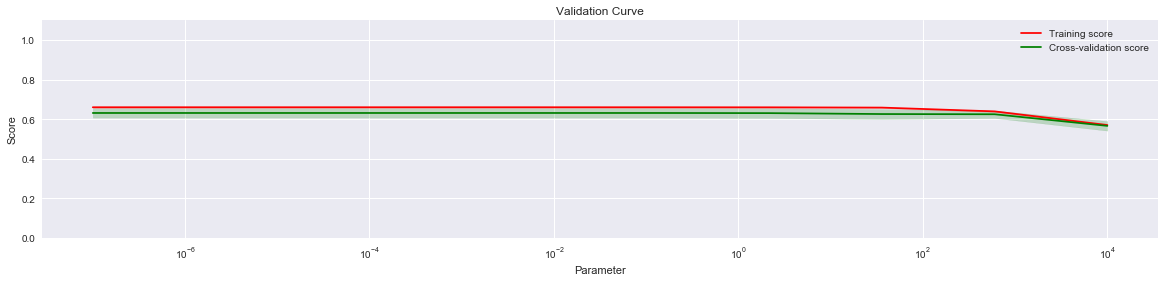

(array([[ 54,  54,   8],
        [ 28, 145, 103],
        [  1,  74, 231]], dtype=int64),
 GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=12, shuffle=True),
        error_score='raise',
        estimator=Pipeline(memory=None,
      steps=[('imputation', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
     verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logclassmord', LogisticIT(alpha=1.0, max_iter=100, verbose=0))]),
        fit_params=None, iid=True, n_jobs=4,
        param_grid={'logclassmord__alpha': array([  1.00000e-07,   1.66810e-06,   2.78256e-05,   4.64159e-04,
          7.74264e-03,   1.29155e-01,   2.15443e+00,   3.59381e+01,
          5.99484e+02,   1.00000e+04])},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=make_scorer(f1_score, average=micro), verbose=0))

In [18]:
# Ordindal regression using the mord package
import mord as m

steps_logclassmord = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                      ('scaler', StandardScaler()),
                      ('logclassmord', m.LogisticIT(max_iter = 100))]
                  
pipeline_logclassmord = Pipeline(steps_logclassmord)

parameters_logclassmord = {'logclassmord__alpha':np.logspace(-7, 4, 10)}

score_func = f1_score
#score_func = cohen_kappa_score
apply_model(X_all, y_three_ranks, pipeline_logclassmord, parameters_logclassmord, 
            valid_param_name = 'logclassmord__alpha', learn_curve = 0, valid_curve = 1, 
            classification=1, nested = True, scoring = score_func,
            random_state = 12)

Model performance via nested cross-validaton mean score:0.629 (+/-0.006)
Accuracy on the test data: 62.32091690544412
Tuned model Parameters: {'logreg__C': 0.0077426368268112772}
             precision    recall  f1-score   support

          1       0.67      0.45      0.54       116
          2       0.55      0.53      0.54       276
          3       0.67      0.77      0.72       306

avg / total       0.62      0.62      0.62       698

Normalized confusion matrix
[[ 0.44827586  0.43103448  0.12068966]
 [ 0.0942029   0.52898551  0.37681159]
 [ 0.          0.2254902   0.7745098 ]]


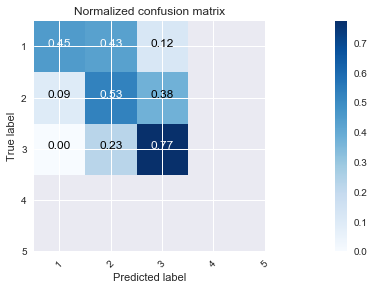

cross-validaiton scores:
0.438 (+/-0.001) for {'logreg__C': 9.9999999999999995e-08}
0.438 (+/-0.001) for {'logreg__C': 1.6681005372000591e-06}
0.521 (+/-0.055) for {'logreg__C': 2.782559402207126e-05}
0.593 (+/-0.052) for {'logreg__C': 0.00046415888336127822}
0.633 (+/-0.040) for {'logreg__C': 0.0077426368268112772}
0.632 (+/-0.051) for {'logreg__C': 0.12915496650148853}
0.631 (+/-0.048) for {'logreg__C': 2.1544346900318865}
0.630 (+/-0.048) for {'logreg__C': 35.938136638046402}
0.630 (+/-0.048) for {'logreg__C': 599.48425031894214}
0.630 (+/-0.048) for {'logreg__C': 10000.0}
training scores:
0.438 (+/-0.000) for {'logreg__C': 9.9999999999999995e-08}
0.438 (+/-0.000) for {'logreg__C': 1.6681005372000591e-06}
0.526 (+/-0.010) for {'logreg__C': 2.782559402207126e-05}
0.612 (+/-0.007) for {'logreg__C': 0.00046415888336127822}
0.680 (+/-0.008) for {'logreg__C': 0.0077426368268112772}
0.688 (+/-0.007) for {'logreg__C': 0.12915496650148853}
0.689 (+/-0.010) for {'logreg__C': 2.15443469003188

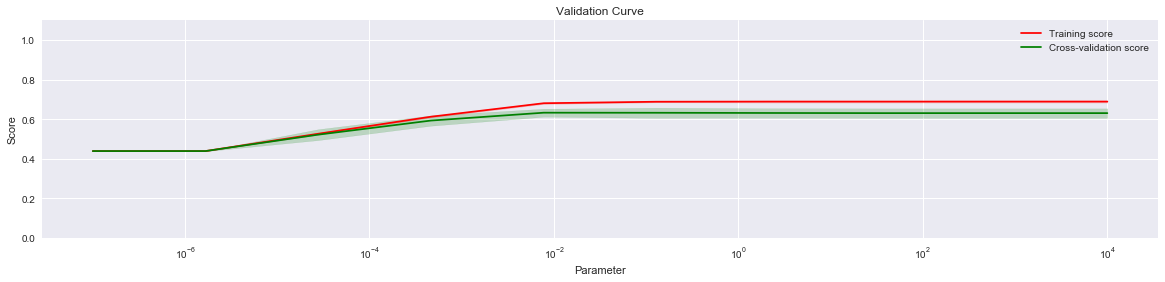

In [19]:
# Logistic regression for multiclass classification
steps_logreg = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(max_iter = 100, solver = 'newton-cg', multi_class = 'multinomial'))]
                  
pipeline_logreg = Pipeline(steps_logreg)

parameters_logreg = {'logreg__C':np.logspace(-7, 4, 10)}


score_func = f1_score

cnf_matrix, cv = apply_model(X_all, y_three_ranks, pipeline_logreg, parameters_logreg, valid_param_name='logreg__C', 
                             scoring = score_func, learn_curve = 0, valid_curve = 1, nested = True, 
                             classification=1, random_state = 12)


Model performance via nested cross-validaton mean score:0.618 (+/-0.009)
Accuracy on the test data: 63.75358166189111
Tuned model Parameters: {'xgboost__n_estimators': 60, 'xgboost__max_depth': 122}
             precision    recall  f1-score   support

          1       0.68      0.41      0.51       116
          2       0.56      0.64      0.60       276
          3       0.71      0.72      0.71       306

avg / total       0.64      0.64      0.63       698

Normalized confusion matrix
[[ 0.40517241  0.50862069  0.0862069 ]
 [ 0.06521739  0.64492754  0.28985507]
 [ 0.0130719   0.26797386  0.71895425]]


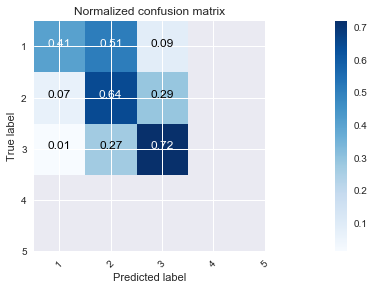

cross-validaiton scores:
0.631 (+/-0.038) for {'xgboost__n_estimators': 60, 'xgboost__max_depth': 122}
0.624 (+/-0.053) for {'xgboost__n_estimators': 70, 'xgboost__max_depth': 2}
0.630 (+/-0.038) for {'xgboost__n_estimators': 90, 'xgboost__max_depth': 122}
0.626 (+/-0.045) for {'xgboost__n_estimators': 130, 'xgboost__max_depth': 122}
0.631 (+/-0.038) for {'xgboost__n_estimators': 60, 'xgboost__max_depth': 62}
0.617 (+/-0.041) for {'xgboost__n_estimators': 150, 'xgboost__max_depth': 2}
0.628 (+/-0.045) for {'xgboost__n_estimators': 120, 'xgboost__max_depth': 82}
0.588 (+/-0.051) for {'xgboost__n_estimators': 10, 'xgboost__max_depth': 2}
0.620 (+/-0.044) for {'xgboost__n_estimators': 20, 'xgboost__max_depth': 102}
0.628 (+/-0.045) for {'xgboost__n_estimators': 120, 'xgboost__max_depth': 42}
training scores:
1.000 (+/-0.000) for {'xgboost__n_estimators': 60, 'xgboost__max_depth': 122}
0.688 (+/-0.007) for {'xgboost__n_estimators': 70, 'xgboost__max_depth': 2}
1.000 (+/-0.000) for {'xgboos

In [20]:
# Fix some parameter values
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=250,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

steps_xgboost = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('xgboost', xgb1)]
pipeline_xgboost = Pipeline(steps_xgboost)

parameters_xgboost = {'xgboost__max_depth':np.arange(2,128, 20),
                      'xgboost__n_estimators':np.arange(10,200, 10)}

cnf_matrix, cv = apply_model(X_all, y_three_ranks, pipeline_xgboost, parameters_xgboost, 
                             valid_param_name='xgboost__max_depth',valid_curve = 0, 
                             learn_curve = 0, classification=1, nested = True, 
                             random_state = 12, feature_imp = False, randomized_search = True,
                             named_step='gbm')

####  Classification using upsampling and the combined rankings 
In this section I first apply a SMOTE upsampling scheme to upsample the training data, I will then measure the f1-score on an unseen test dataset using multiple random seed selections. As can be seen from the results, the average f1-scores do not deomnstrate an improvement. What we observe that the performance of the classifier improves for the class 1 ratings in terms of the computed precision and recall, however the ones for the average class 2 decreases comparing to before sampling. This can be due to decreases influence of the hospitals with combined ratings of 2 on the classification after we upsample the observations from class 1.

|<center>Model</center>||seed=12||seed=20||seed=42|Average|
|----------------------||-------||-------||-------|--------------------------------------|
|<center>SVM</center> || <center>$0.61$ </center>||<center>$0.62$</center>||<center>$0.63$</center>||<center>$0.62$</center>|
|<center>Gradient Boosting</center> || <center>$0.64$</center>|| <center>$0.62$</center>||<center> $0.65$</center>||<center>$0.64$</center>|
|<center>Logistic Regression</center>|| <center>$0.61$</center>|| <center>$0.62$</center>||<center>$0.62$</center>||<center>$0.62$</center> |

Dimensions of y_ros: (3672,)
Dimension of X_ros: (3672, 121)
[(1, 1224), (2, 1224), (3, 1224)]
Accuracy on the test data: 63.180515759312314
             precision    recall  f1-score   support

          1       0.57      0.72      0.63       116
          2       0.57      0.51      0.54       276
          3       0.71      0.71      0.71       306

avg / total       0.63      0.63      0.63       698

Normalized confusion matrix
[[ 0.71551724  0.21551724  0.06896552]
 [ 0.19202899  0.51449275  0.29347826]
 [ 0.03267974  0.26143791  0.70588235]]


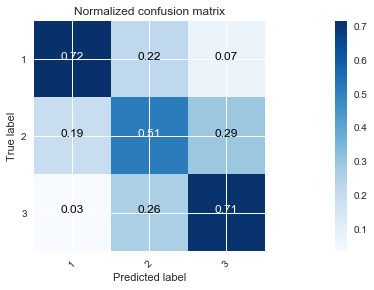

In [51]:
steps_svm_mean = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                  ('scaler', StandardScaler()),
                  ('SVM', svm.SVC(gamma=0.001))]
pipeline_svm = Pipeline(steps_svm_mean)

# Specify the hyperparameter space
parameters_svm = {'SVM__C':10}

cnf_matrix = apply_model_with_resampling(X_all, y_three_ranks, pipeline_svm, parameters_svm, 
                                         classes = ['1', '2', '3'], random_state=42, scheme = 'SMOTE')

Dimensions of y_ros: (3672,)
Dimension of X_ros: (3672, 121)
[(1, 1224), (2, 1224), (3, 1224)]
Accuracy on the test data: 65.0429799426934
             precision    recall  f1-score   support

          1       0.69      0.52      0.59       116
          2       0.57      0.64      0.60       276
          3       0.72      0.71      0.72       306

avg / total       0.66      0.65      0.65       698

Normalized confusion matrix
[[ 0.51724138  0.42241379  0.06034483]
 [ 0.08695652  0.63768116  0.27536232]
 [ 0.00980392  0.27777778  0.7124183 ]]


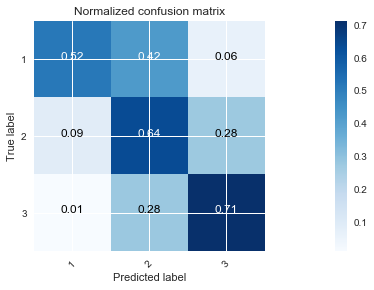

In [54]:
# Gradient boosting
steps_gbm = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
             ('scaler', StandardScaler()),
             ('gbm', GradientBoostingClassifier(random_state=0, learning_rate=0.1))]
pipeline_gbm = Pipeline(steps_gbm)

parameters_gbm = {'gbm__n_estimators':62,
                  'gbm__subsample':0.9,
                  'gbm__max_depth':13,
                  'gbm__min_samples_split':32,
                  'gbm__min_samples_leaf':6,
                  'gbm__max_features':19}

                        
cnf_matrix = apply_model_with_resampling(X_all, y_three_ranks, pipeline_gbm, parameters_gbm, 
                                         classes = ['1', '2', '3'], random_state=42, scheme = 'SMOTE')

Dimensions of y_ros: (3672,)
Dimension of X_ros: (3672, 121)
[(1, 1224), (2, 1224), (3, 1224)]
Accuracy on the test data: 62.89398280802292
             precision    recall  f1-score   support

          1       0.54      0.75      0.63       116
          2       0.59      0.47      0.52       276
          3       0.70      0.73      0.71       306

avg / total       0.63      0.63      0.62       698

Normalized confusion matrix
[[ 0.75        0.17241379  0.07758621]
 [ 0.2173913   0.47101449  0.3115942 ]
 [ 0.04248366  0.23202614  0.7254902 ]]


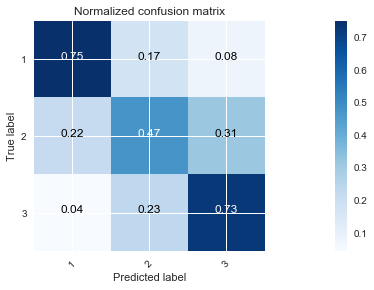

In [60]:
# Logistic regression
steps_logreg = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                 ('scaler', StandardScaler()),
                 ('logreg', LogisticRegression(max_iter = 100, solver = 'newton-cg', multi_class = 'multinomial'))]
                  
pipeline_logreg = Pipeline(steps_logreg)

parameters_logreg = {'logreg__C':0.007}

cnf_matrix = apply_model_with_resampling(X_all, y_three_ranks, pipeline_logreg, parameters_logreg, 
                                         classes = ['1', '2', '3'], random_state=42, scheme = 'SMOTE')

#### Classification after removal of missing and correlated features 


['OP_12_Yes']
Model performance via nested cross-validaton mean score:0.571 (+/-0.019)
Accuracy on the test data: 56.87679083094556
Tuned model Parameters: {'SVM__C': 10.0}
             precision    recall  f1-score   support

          1       0.67      0.18      0.29        11
          2       0.58      0.37      0.45       105
          3       0.54      0.57      0.55       276
          4       0.59      0.73      0.65       267
          5       0.75      0.08      0.14        39

avg / total       0.58      0.57      0.55       698

Normalized confusion matrix
[[ 0.18181818  0.63636364  0.18181818  0.          0.        ]
 [ 0.          0.37142857  0.57142857  0.05714286  0.        ]
 [ 0.          0.07246377  0.57246377  0.35507246  0.        ]
 [ 0.00374532  0.          0.26217228  0.73033708  0.00374532]
 [ 0.          0.02564103  0.1025641   0.79487179  0.07692308]]


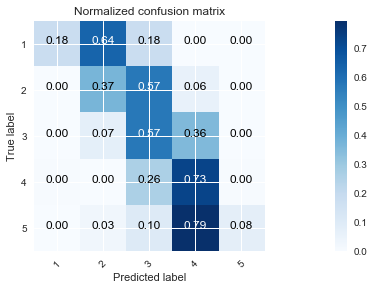

cross-validaiton scores:
0.395 (+/-0.002) for {'SVM__C': 9.9999999999999995e-08}
0.395 (+/-0.002) for {'SVM__C': 2.1544346900318822e-06}
0.395 (+/-0.002) for {'SVM__C': 4.6415888336127723e-05}
0.395 (+/-0.002) for {'SVM__C': 0.001}
0.395 (+/-0.002) for {'SVM__C': 0.021544346900318822}
0.531 (+/-0.039) for {'SVM__C': 0.46415888336127725}
0.579 (+/-0.052) for {'SVM__C': 10.0}
0.521 (+/-0.073) for {'SVM__C': 215.44346900318777}
0.490 (+/-0.052) for {'SVM__C': 4641.5888336127728}
0.491 (+/-0.056) for {'SVM__C': 100000.0}
training scores:
0.395 (+/-0.000) for {'SVM__C': 9.9999999999999995e-08}
0.395 (+/-0.000) for {'SVM__C': 2.1544346900318822e-06}
0.395 (+/-0.000) for {'SVM__C': 4.6415888336127723e-05}
0.395 (+/-0.000) for {'SVM__C': 0.001}
0.395 (+/-0.000) for {'SVM__C': 0.021544346900318822}
0.548 (+/-0.006) for {'SVM__C': 0.46415888336127725}
0.682 (+/-0.007) for {'SVM__C': 10.0}
0.949 (+/-0.006) for {'SVM__C': 215.44346900318777}
1.000 (+/-0.000) for {'SVM__C': 4641.5888336127728}
1.00

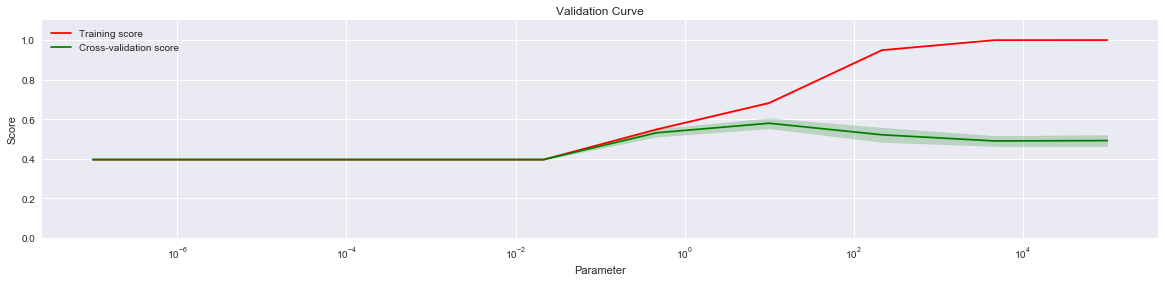

In [75]:
df_tmp, X_less, features = remove_missing_features(df,Threshold = 0.6)
_, X_less, features = remove_correlated_features(df_tmp,Threshold = 0.8)

steps_svm_mean = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                  ('scaler', StandardScaler()),
                  ('SVM', svm.SVC(gamma=0.001))]
pipeline_svm = Pipeline(steps_svm_mean)

# Specify the hyperparameter space
parameters_svm = {'SVM__C':np.logspace(-7, 5, 10)}


cnf_matrix = apply_model(X_less, y, pipeline_svm, parameters_svm, 
                        valid_param_name='SVM__C', valid_curve = 1, 
                        learn_curve = 0, classification=1, nested = True, feature_names = features, 
                        random_state = 12, feature_imp = False, randomized_search = False)


#### Conclusion


In [ ]:
# Combination of PCA and SVM
#from sklearn import decomposition

# Setup the pipeline
#steps_svm_pca = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
#                 ('scaler', StandardScaler()),
#                 ('pca', decomposition.PCA()),
#                 ('SVM', svm.SVC())]
#pipeline_svm_pca = Pipeline(steps_svm_pca)

# Specify the hyperparameter space
#parameters = {'SVM__C':[0.01, 0.1, 1, 10, 100],
#              #'SVM__kernel':['linear','rbf'],
#              'SVM__gamma':[0.01, 0.1, 1, 10],
#              'pca__n_components':[20, 40, 64]}

#apply_model(X_all, y, pipeline_svm_pca, parameters)


In [ ]:
# Specify the hyperparameter space
#parameters = {'SVM__C':[0.01, 0.1, 1, 10],
#              'SVM__gamma':[0.01, 0.1, 1, 10]}

#cnf_matrix = apply_model(X_all, y_three_ranks, pipeline_svm_mf, parameters)

In [ ]:
# Play with some feature selection strategies
#from sklearn import feature_selection
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

 
#steps_svm_fs = [('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
#                ('scaler', StandardScaler()),
#                ('anova', SelectKBest()),
#                ('SVM', svm.SVC())]
#pipeline_svm_fs = Pipeline(steps_svm_fs)

# Specify the hyperparameter space
#parameters = {'SVM__C':[0.01, 0.1, 1, 10],
#              'SVM__gamma':[0.01, 0.1, 1, 10],
#              'anova__k':[10,20,40,80],
#              'anova__score_func':[f_classif, mutual_info_classif]}

#apply_model(X_all, y_three_ranks, pipeline_svm_fs, parameters)
#apply_model(X_all, y, pipeline_svm_fs, parameters)

In [ ]:
# Feature selection with RFE seems to be taking a loooong time! 

# First do some linear SVM to select features
#estimator = svm.SVC(kernel="linear")
#selector = feature_selection.RFE(estimator, 40)

#imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
#imp.fit(X_all)
#X_all = imp.transform(X_all)
#estimator = svm.SVC(kernel="linear")
#selector = feature_selection.RFE(estimator, 5)
#X_all = selector.fit_transform(X_all,y)

#steps_svm_fs_2 = [#('imputatoin', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                  #('feature_selection', selector),
                  #('scaler', StandardScaler()),
                  #('SVM', svm.SVC())]
#pipeline_svm_fs_2 = Pipeline(steps_svm_fs_2)

# Specify the hyperparameter space
#parameters = {'SVM__C':[ 1],
#              'SVM__gamma':[0.01]}

#apply_model(X_all, y, pipeline_svm_fs_2, parameters)
